<a href="https://colab.research.google.com/github/arnav-meduri/PVO-segmentation/blob/main/pytorch_unet_resnet18_arnav_oct_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## pytorch-uent

https://github.com/usuyama/pytorch-unet

In [ ]:
import os

if not os.path.exists("pytorch_unet.py"):
  if not os.path.exists("pytorch_unet"):
    !git clone https://github.com/usuyama/pytorch-unet.git

  %cd pytorch-unet

fatal: destination path 'pytorch-unet' already exists and is not an empty directory.
/content/pytorch-unet


In [ ]:
!pip install 'git+https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup'

  Cloning https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup to /tmp/pip-req-build-hejkze75
  Running command git clone --filter=blob:none --quiet https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup /tmp/pip-req-build-hejkze75
  Resolved https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup to commit 12d03c07553aedd3d9e9155e2b3e31ce8c64081a
  Preparing metadata (setup.py) ... done


## Enabling GPU on Colab

Need to enable GPU from Notebook settings

- Navigate to Edit-Notebook settings menu
- Select GPU from the Hardware Accelerator dropdown list


In [ ]:
import torch

if not torch.cuda.is_available():
  raise Exception("GPU not availalbe. CPU training will be too slow.")

print("device name", torch.cuda.get_device_name(0))

device name Tesla T4


## Synthetic images for demo training

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
! ls "/content/drive/.shortcut-targets-by-id/1Gd6Qvx67HvZr5HE48UMhRc2vhUfBl1Jh/PVO_Segmentation_Project/Processed_Images/jul29/BB_Annotated_Masked_Gray_Downsampled_ALL/" | wc -l

71


In [ ]:
! mkdir -p /content/Original_Images
! mkdir -p /content/Masked_Images
#orig_folder = "/content/drive/MyDrive/RCompSci/Normalized_Images/jul20/original/"
orig_folder = "/content/drive/.shortcut-targets-by-id/125hZPAYBuLFazUxcCNp-tOVUTlu9GOqJ/RCompSci/Normalized_Images/jul20/original/"
!cp "$orig_folder"/*.png /content/Original_Images/
masked_folder = "/content/drive/.shortcut-targets-by-id/1Gd6Qvx67HvZr5HE48UMhRc2vhUfBl1Jh/PVO_Segmentation_Project/Processed_Images/jul29/BB_Annotated_Masked_Gray_Downsampled_ALL/"
!cp "$masked_folder"/*.png /content/Masked_Images/
model_path = "/content/drive/.shortcut-targets-by-id/1Gd6Qvx67HvZr5HE48UMhRc2vhUfBl1Jh/PVO_Segmentation_Project/Processed_Images/"
!cp "$model_path"/*.pth /content/

In [ ]:
!cp "$orig_folder"/"24 OS-3.png" /content/Original_Images/

In [ ]:
!ls /content/Original_Images/ | wc -l
!ls /content/Masked_Images/ | wc -l

82
71


# Left: Input image (black and white), Right: Target mask (6ch)

In [ ]:
import torch
from torchvision import datasets, transforms
import glob
from PIL import Image
import numpy as np
import os
folder_image = glob.glob("/content/Original_Images/*.png")
folder_mask = glob.glob("/content/Masked_Images/*.png")
len_data = len(folder_image)
print(len_data)
len_mask = len(folder_mask)
print(len_mask)
image_list = []
mask_list = []
file_list = []
for path in folder_mask:
  # Extract .png
  #file = path[24:41]
  file = path.split('/')[-1]
  print(f'path={path}')
  print(f'file={file}')

  mask_list.append(path)

  file_list.append(file)
path = '/content/Original_Images/'
for file in file_list:
  if os.path.isfile(os.path.join(path, file)):
    image_list.append(os.path.join(path, file))
    image = Image.open(os.path.join(path, file))
    image = np.asarray(image)
    #print(f'np.max(image)={np.max(image)}')
    #print(f'image={image}')
  else:
    print(f'not a file = {file}')

print(f'len(image_list)={len(image_list)}')


82
71
path=/content/Masked_Images/240 OD-4.png
file=240 OD-4.png
path=/content/Masked_Images/690 OS-1.png
file=690 OS-1.png
path=/content/Masked_Images/45 OS-5.png
file=45 OS-5.png
path=/content/Masked_Images/152 OD-5.png
file=152 OD-5.png
path=/content/Masked_Images/45 OS-2.png
file=45 OS-2.png
path=/content/Masked_Images/275 OD-5.png
file=275 OD-5.png
path=/content/Masked_Images/483 OS-2.png
file=483 OS-2.png
path=/content/Masked_Images/357 OD-4.png
file=357 OD-4.png
path=/content/Masked_Images/966 OD-1.png
file=966 OD-1.png
path=/content/Masked_Images/24 OS-4.png
file=24 OS-4.png
path=/content/Masked_Images/152 OD-2.png
file=152 OD-2.png
path=/content/Masked_Images/694 OS-3.png
file=694 OS-3.png
path=/content/Masked_Images/240 OD-5.png
file=240 OD-5.png
path=/content/Masked_Images/261 OD-2.png
file=261 OD-2.png
path=/content/Masked_Images/1 OS-4.png
file=1 OS-4.png
path=/content/Masked_Images/357 OD-3.png
file=357 OD-3.png
path=/content/Masked_Images/480 OD-3.png
file=480 OD-3.png
p

In [ ]:
# temporarily change train size to zero
#train_size = 0.7
train_size = 0.0
len_data = len(image_list)
print(f'total # of images: {len_data}')
train_image_paths = image_list[:int(len_data*train_size)]
test_image_paths = image_list[int(len_data*train_size):]

train_mask_paths = mask_list[:int(len_data*train_size)]
test_mask_paths = mask_list[int(len_data*train_size):]

print(f'number of images for training: {len(train_image_paths)}')
print(f'number of images for testing: {len(test_image_paths)}')

print(f'training with images: {train_image_paths}')
print(f'training mask images: {train_mask_paths}')
print(f'testing with images: {test_image_paths}')
print(f'testing mask images: {test_mask_paths}')

total # of images: 71
number of images for training: 0
number of images for testing: 71
training with images: []
training mask images: []
testing with images: ['/content/Original_Images/240 OD-4.png', '/content/Original_Images/690 OS-1.png', '/content/Original_Images/45 OS-5.png', '/content/Original_Images/152 OD-5.png', '/content/Original_Images/45 OS-2.png', '/content/Original_Images/275 OD-5.png', '/content/Original_Images/483 OS-2.png', '/content/Original_Images/357 OD-4.png', '/content/Original_Images/966 OD-1.png', '/content/Original_Images/24 OS-4.png', '/content/Original_Images/152 OD-2.png', '/content/Original_Images/694 OS-3.png', '/content/Original_Images/240 OD-5.png', '/content/Original_Images/261 OD-2.png', '/content/Original_Images/1 OS-4.png', '/content/Original_Images/357 OD-3.png', '/content/Original_Images/480 OD-3.png', '/content/Original_Images/261 OD-3.png', '/content/Original_Images/352 OS-1.png', '/content/Original_Images/24 OS-1.png', '/content/Original_Images/

In [ ]:
from torch.utils.data.dataset import Dataset
class CustomDataset(Dataset):
    def __init__(self, image_paths, target_paths, train=True):   # initial logic


         self.image_paths = image_paths
         self.target_paths = target_paths
         self.transforms = transforms.ToTensor()

    def __getitem__(self, index):

        image = Image.open(self.image_paths[index])

        mask = Image.open(self.target_paths[index])
        # print(np.max(np.asarray(image)))
        # print(np.max(np.asarray(mask)))
        t_image = self.transforms(image)
        t_mask = self.transforms(mask)
        t_mask[t_mask>0] = 1

        t_image = t_image.repeat(3, 1, 1)
        return t_image, t_mask

    def __len__(self):  # return count of sample we have

        return len(self.image_paths)


batch_size = 8


train_dataset = CustomDataset(train_image_paths, train_mask_paths, train=True)
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=1)

test_dataset = CustomDataset(test_image_paths, test_mask_paths, train=False)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=1)
dataloaders = {
  # temporarily disable tarin dataloader
  #'train': torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1),
  'val': torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)
}

## Prepare Dataset and DataLoader

## Check the outputs from DataLoader

247
(512, 512, 3) torch.Size([8, 3, 512, 512])


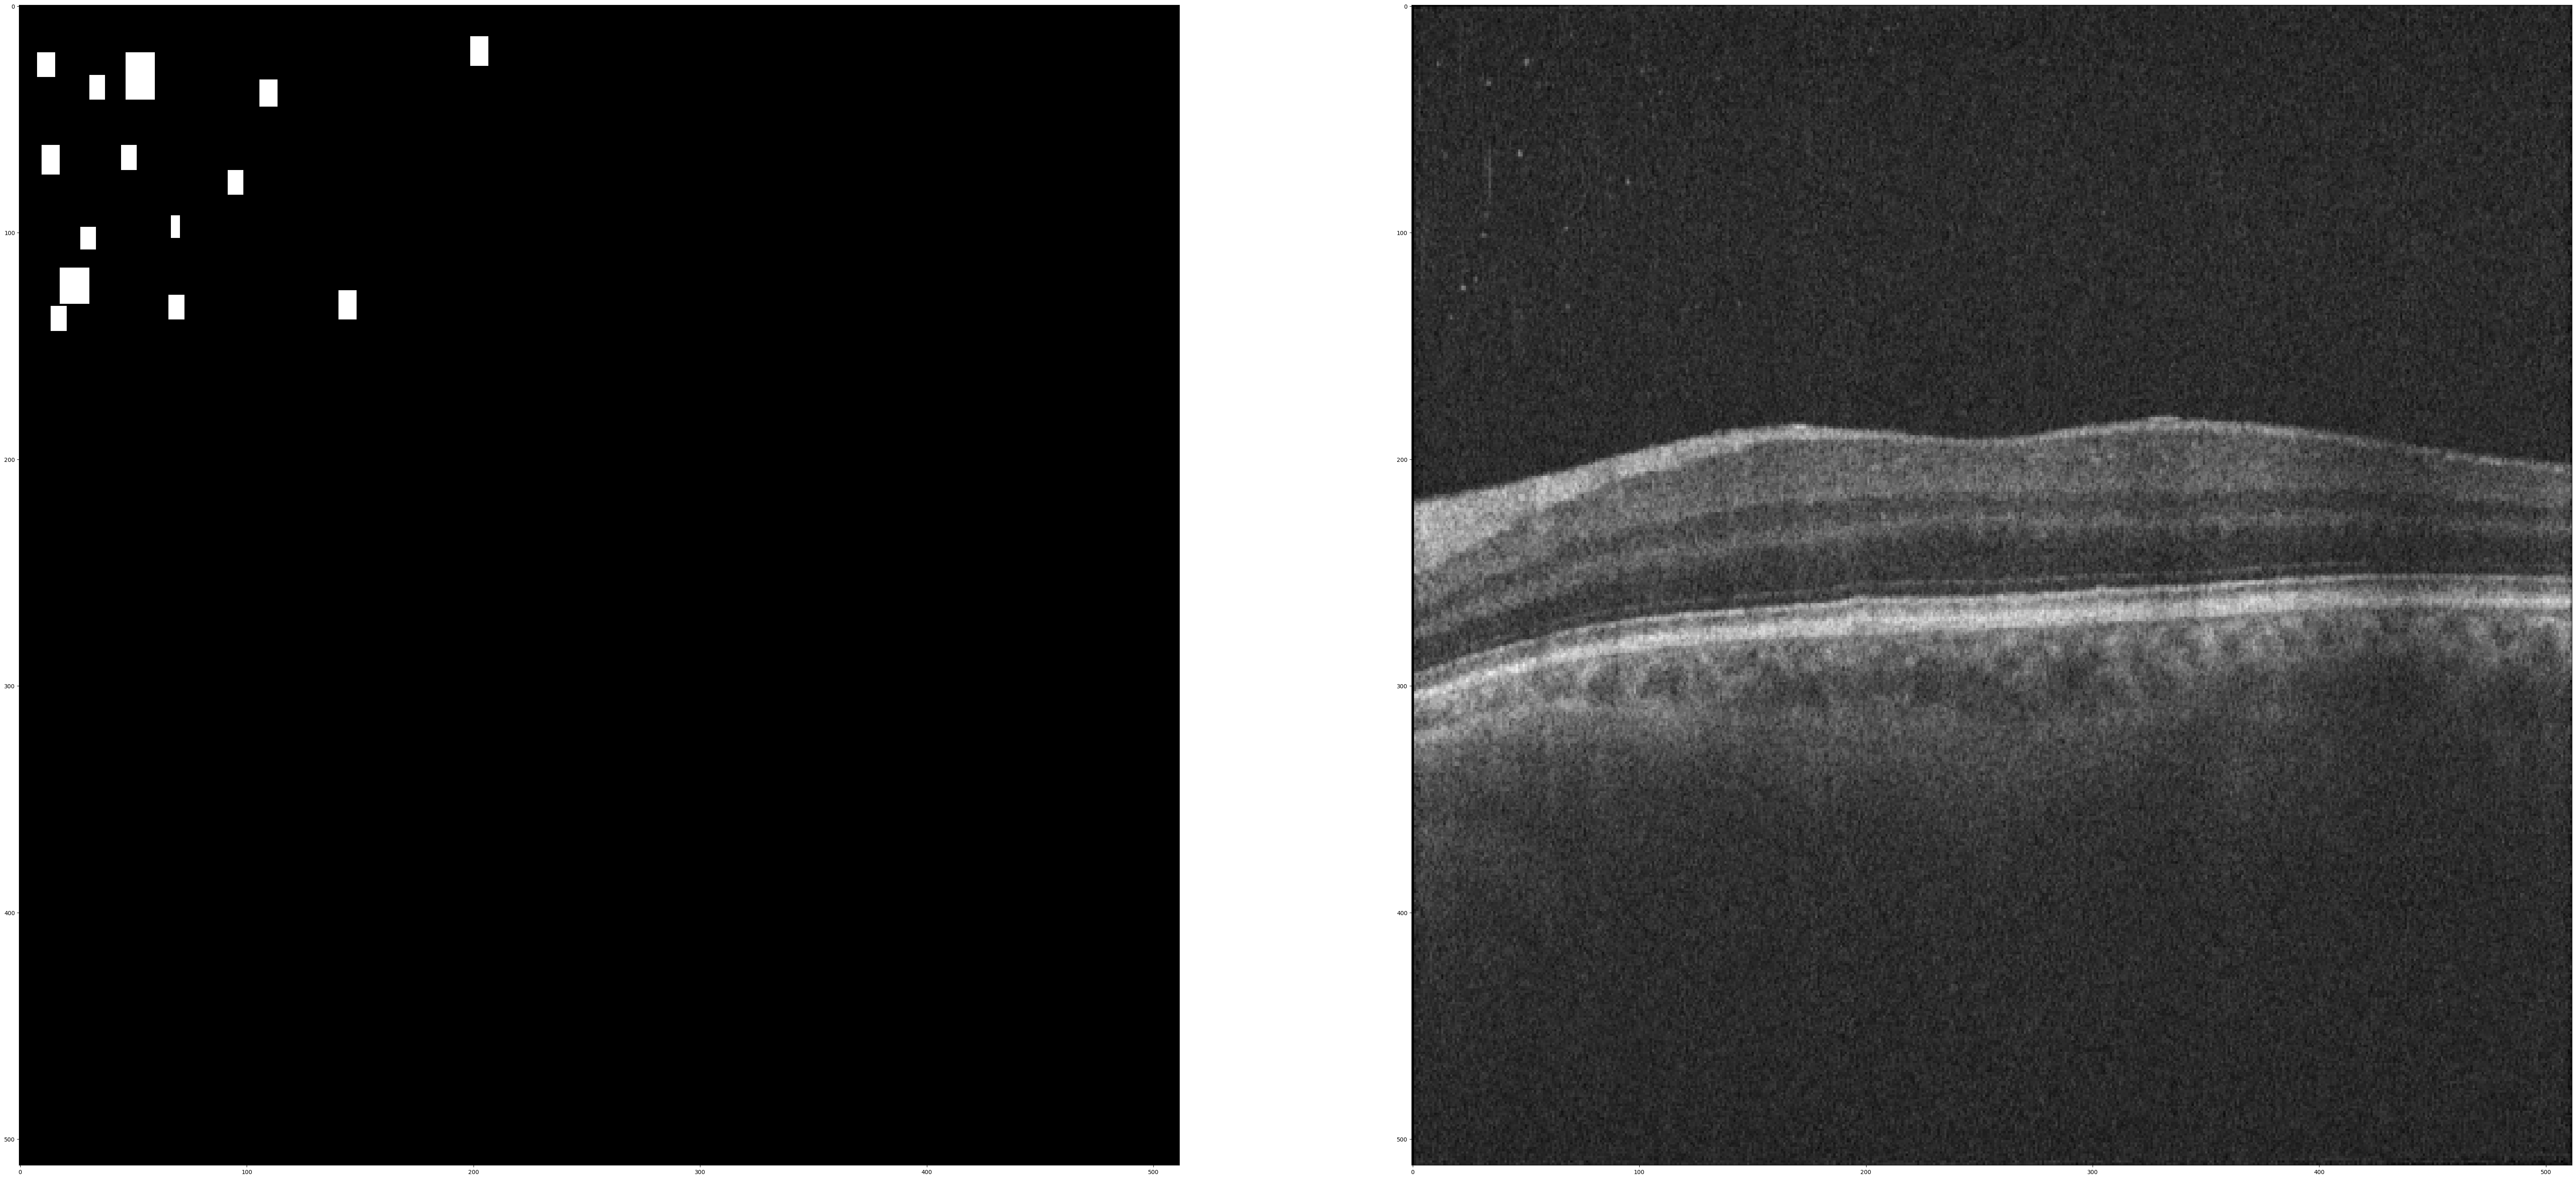

In [ ]:
import torchvision.utils
from matplotlib import pyplot as plt
def reverse_transform(inp):
  inp = inp.numpy().transpose((1, 2, 0))
  # mean = np.array([0.485, 0.456, 0.406])
  # std = np.array([0.229, 0.224, 0.225])
  # inp = std * inp + mean
  # inp = np.clip(inp, 0, 1)
  inp = (inp * 255).astype(np.uint8)
  print(np.max(inp))
  return np.squeeze(inp)

# Get a batch of training data
# temporarily change from 'train' to 'val'
inputs, masks = next(iter(dataloaders['val']))

print(reverse_transform(inputs[3]).shape, inputs.shape)
rows =1
columns =2
val_index = 2
fig = plt.figure(figsize=(80, 40))
fig.add_subplot(rows, columns, 1)
plt.imshow(np.squeeze(masks[val_index]),cmap='gray', vmin=0, vmax=1)
fig.add_subplot(rows, columns, 2)
plt.imshow(np.squeeze(inputs[val_index][1,:,:]),cmap='gray', vmin=0, vmax=1)
# print(torch.max(inputs))
# print(torch.histc(masks))

# Define a UNet module

In [ ]:
import torch.nn as nn
import torchvision.models


def convrelu(in_channels, out_channels, kernel, padding):
  return nn.Sequential(
    nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
    nn.ReLU(inplace=True),
  )


class ResNetUNet(nn.Module):
  def __init__(self, n_class):
    super().__init__()

    self.base_model = torchvision.models.resnet18(pretrained=True)
    self.base_layers = list(self.base_model.children())

    self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
    self.layer0_1x1 = convrelu(64, 64, 1, 0)
    self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
    self.layer1_1x1 = convrelu(64, 64, 1, 0)
    self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
    self.layer2_1x1 = convrelu(128, 128, 1, 0)
    self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
    self.layer3_1x1 = convrelu(256, 256, 1, 0)
    self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
    self.layer4_1x1 = convrelu(512, 512, 1, 0)

    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
    self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
    self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
    self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

    self.conv_original_size0 = convrelu(3, 64, 3, 1)
    self.conv_original_size1 = convrelu(64, 64, 3, 1)
    self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

    self.conv_last = nn.Conv2d(64, n_class, 1)

  def forward(self, input):
    x_original = self.conv_original_size0(input)
    x_original = self.conv_original_size1(x_original)

    layer0 = self.layer0(input)
    layer1 = self.layer1(layer0)
    layer2 = self.layer2(layer1)
    layer3 = self.layer3(layer2)
    layer4 = self.layer4(layer3)

    layer4 = self.layer4_1x1(layer4)
    x = self.upsample(layer4)
    layer3 = self.layer3_1x1(layer3)
    x = torch.cat([x, layer3], dim=1)
    x = self.conv_up3(x)

    x = self.upsample(x)
    layer2 = self.layer2_1x1(layer2)
    x = torch.cat([x, layer2], dim=1)
    x = self.conv_up2(x)

    x = self.upsample(x)
    layer1 = self.layer1_1x1(layer1)
    x = torch.cat([x, layer1], dim=1)
    x = self.conv_up1(x)

    x = self.upsample(x)
    layer0 = self.layer0_1x1(layer0)
    x = torch.cat([x, layer0], dim=1)
    x = self.conv_up0(x)

    x = self.upsample(x)
    x = torch.cat([x, x_original], dim=1)
    x = self.conv_original_size2(x)

    out = self.conv_last(x)

    return out

## Instantiate the UNet model

- Move the model to GPU if available
- Show model summaries

In [ ]:
import torch
import torch.nn as nn
import pytorch_unet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device', device)

model = ResNetUNet(1)
model = model.to(device)
torch.set_num_threads(20)

device cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model

ResNetUNet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [ ]:
from torchsummary import summary
summary(model, input_size=(3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           1,792
              ReLU-2         [-1, 64, 512, 512]               0
            Conv2d-3         [-1, 64, 512, 512]          36,928
              ReLU-4         [-1, 64, 512, 512]               0
            Conv2d-5         [-1, 64, 256, 256]           9,408
            Conv2d-6         [-1, 64, 256, 256]           9,408
       BatchNorm2d-7         [-1, 64, 256, 256]             128
       BatchNorm2d-8         [-1, 64, 256, 256]             128
              ReLU-9         [-1, 64, 256, 256]               0
             ReLU-10         [-1, 64, 256, 256]               0
        MaxPool2d-11         [-1, 64, 128, 128]               0
        MaxPool2d-12         [-1, 64, 128, 128]               0
           Conv2d-13         [-1, 64, 128, 128]          36,864
           Conv2d-14         [-1, 64, 1

# Define the main training loop (Disabled Temporarily)

In [ ]:
# from collections import defaultdict
# import torch.nn.functional as F
# from loss import dice_loss

# checkpoint_path = "checkpoint_bce_81_bce01.pth"

# def calc_loss(pred, target, metrics, bce_weight=0.5):
#     bce = F.binary_cross_entropy_with_logits(pred, target)

#     pred = torch.sigmoid(pred)
#     dice = dice_loss(pred, target)

#     loss = bce * bce_weight + dice * (1 - bce_weight)

#     metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
#     metrics['dice loss'] += dice.data.cpu().numpy() * target.size(0)
#     metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

#     return loss

# def print_metrics(metrics, epoch_samples, phase):
#     outputs = []
#     for k in metrics.keys():
#         outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

#     print("{}: {}".format(phase, ", ".join(outputs)))

# def train_model(model, optimizer, scheduler, num_epochs=25):
#     best_loss = 1e10
#     best_epoch = -1
#     for epoch in range(num_epochs):
#         print('Epoch {}/{}'.format(epoch, num_epochs - 1))
#         print('-' * 10)

#         since = time.time()

#         # Each epoch has a training and validation phase
#         for phase in ['train', 'val']:
#             if phase == 'train':
#                 model.train()  # Set model to training mode
#             else:
#                 model.eval()   # Set model to evaluate mode

#             metrics = defaultdict(float)
#             epoch_samples = 0

#             for inputs, labels in dataloaders[phase]:
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)

#                 # zero the parameter gradients
#                 optimizer.zero_grad()

#                 # forward
#                 # track history if only in train
#                 with torch.set_grad_enabled(phase == 'train'):
#                     outputs = model(inputs)
#                     loss = calc_loss(outputs, labels, metrics, bce_weight=0.1)

#                     # backward + optimize only if in training phase
#                     if phase == 'train':
#                         loss.backward()
#                         optimizer.step()
#                         scheduler.step()
# #                         print("LR",optimizer.param_groups[-1]['lr'])
#                 # statistics
#                 epoch_samples += inputs.size(0)

#             print_metrics(metrics, epoch_samples, phase)
#             epoch_loss = metrics['loss'] / epoch_samples

#             if phase == 'train':

#               for param_group in optimizer.param_groups:
#                   print("LR", param_group['lr'])

#             # save the model weights
#             if phase == 'val' and epoch_loss < best_loss:
#                 print(f"saving best model to {checkpoint_path}")
#                 best_loss = epoch_loss
#                 best_epoch = epoch
#                 torch.save(model.state_dict(), checkpoint_path)

#         time_elapsed = time.time() - since
#         print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

#     print('Best val loss: {:4f}'.format(best_loss))

#     # load best model weights
#     model.load_state_dict(torch.load(checkpoint_path))
#     return model

## Training

In [ ]:
# import torch
# import torch.optim as optim
# from torch.optim import lr_scheduler
# import time
# from cosine_annealing_warmup import CosineAnnealingWarmupRestarts

# num_class = 1
# model = ResNetUNet(num_class).to(device)

# # freeze backbone layers
# for l in model.base_layers:
#   for param in l.parameters():
#     param.requires_grad = False

# optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-4)
# # optimizer_ft = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, momentum=0.9,weight_decay = 0.0005)
# scheduler = CosineAnnealingWarmupRestarts(optimizer_ft,
#                                           first_cycle_steps=200,
#                                           cycle_mult=1.0,
#                                           max_lr=0.001,
#                                           min_lr=0.00001,
#                                           warmup_steps=10,
#                                           gamma=1.0)
# # exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=8, gamma=0.1)

# model = train_model(model, optimizer_ft, scheduler, num_epochs=300)

Epoch 0/299
----------
train: bce: 0.479859, dice loss: 0.995760, loss: 0.944170
LR 0.0007030000000000001
val: bce: 0.148074, dice loss: 0.995590, loss: 0.910838
saving best model to checkpoint_bce_81_bce01.pth
0m 3s
Epoch 1/299
----------
train: bce: 0.221735, dice loss: 0.995084, loss: 0.917749
LR 0.0009989177454732933
val: bce: 0.087090, dice loss: 0.993948, loss: 0.903262
saving best model to checkpoint_bce_81_bce01.pth
0m 3s
Epoch 2/299
----------
train: bce: 0.037809, dice loss: 0.995593, loss: 0.899815
LR 0.0009918350120618293
val: bce: 0.031519, dice loss: 0.996510, loss: 0.900011
saving best model to checkpoint_bce_81_bce01.pth
0m 3s
Epoch 3/299
----------
train: bce: 0.021103, dice loss: 0.995516, loss: 0.898075
LR 0.000978237711859507
val: bce: 0.051149, dice loss: 0.995719, loss: 0.901262
0m 2s
Epoch 4/299
----------
train: bce: 0.028195, dice loss: 0.994704, loss: 0.898053
LR 0.0009583077966942535
val: bce: 0.040077, dice loss: 0.995817, loss: 0.900243
0m 2s
Epoch 5/299
--

## Predict new images using the trained model

In [ ]:
# # save the model to file
# torch.save(model.state_dict(), "/content/model_08_24_2023.pth")

In [ ]:
# import math
# device = 'cpu'
# model.eval()   # Set model to the evaluation mode

# # Create a new simulation dataset for testing
# # test_dataset = SimDataset(3, transform = trans)
# # test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, num_workers=0)
# # Val batch size is the length of validation set
# batch_size = len(test_image_paths)
# print(batch_size)
# dataloaders = {
#   'val': torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)
# }

# # Get the first batch
# inputs, masks =  next(iter(dataloaders['val']))
# inputs = inputs.to(device)
# labels = masks.to(device)
# model = model.to(device)
# print('inputs.shape', inputs[1].shape)
# print('labels.shape', labels.shape)

# # Predict
# pred = model(inputs)
# # The loss functions include the sigmoid function.
# pred = torch.sigmoid(pred)
# pred = pred.data.cpu().numpy()
# inputs = inputs.data.cpu().numpy()
# print('pred.shape', pred.shape)
# print('pred.max', np.max(pred))
# # rows =1
# # columns =3

# # for i in range(batch_size):
# #     fig = plt.figure(figsize=(80, 40))
# #     val_index = i
# #     fig.add_subplot(rows, columns, 1)
# #     plt.title('Prediction',fontsize=60)
# #     plt.imshow(np.squeeze(pred[val_index]),cmap='gray', vmin=0, vmax=1)
# #     fig.add_subplot(rows, columns, 2)
# #     plt.title('Image',fontsize=60)
# #     plt.imshow(np.squeeze(inputs[val_index][0,:,:]),cmap='gray', vmin=0, vmax=1)
# #     fig.add_subplot(rows, columns, 3)
# #     plt.title('Ground-Truth',fontsize=60)
# #     plt.imshow(np.squeeze(masks[val_index]),cmap='gray', vmin=0, vmax=1)


22
inputs.shape torch.Size([3, 512, 512])
labels.shape torch.Size([22, 1, 512, 512])
pred.shape (22, 1, 512, 512)
pred.max 1.0


In [ ]:
save_dir = '/content/Predicted_Images'
os.makedirs(save_dir, exist_ok=True)


saving prediction image /content/Predicted_Images/966 OD-1.png


<ipython-input-55-63e61c211843>:7: UserWarning: /content/Predicted_Images/966 OD-1.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


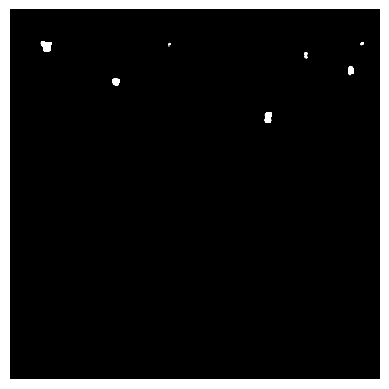

saving prediction image /content/Predicted_Images/690 OS-1.png


<ipython-input-55-63e61c211843>:7: UserWarning: /content/Predicted_Images/690 OS-1.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


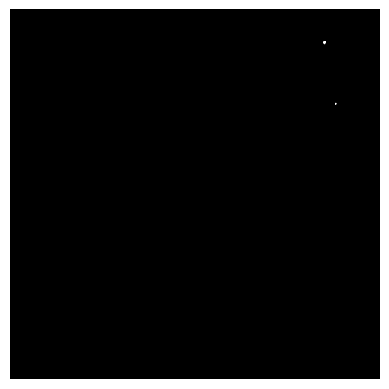

saving prediction image /content/Predicted_Images/694 OS-4.png


<ipython-input-55-63e61c211843>:7: UserWarning: /content/Predicted_Images/694 OS-4.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


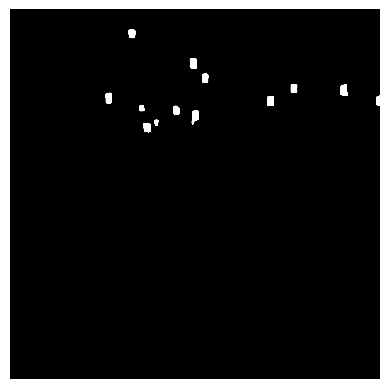

saving prediction image /content/Predicted_Images/261 OD-2.png


<ipython-input-55-63e61c211843>:7: UserWarning: /content/Predicted_Images/261 OD-2.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


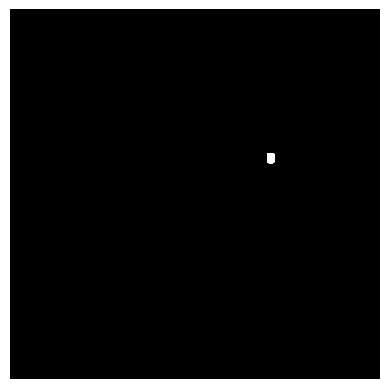

saving prediction image /content/Predicted_Images/934 OD-3.png


<ipython-input-55-63e61c211843>:7: UserWarning: /content/Predicted_Images/934 OD-3.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


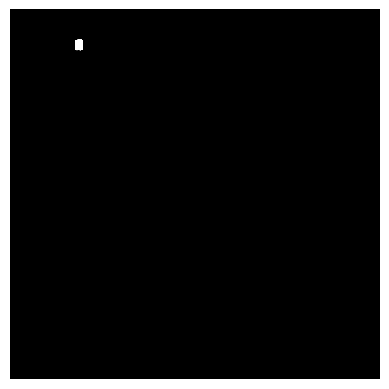

saving prediction image /content/Predicted_Images/357 OD-1.png


<ipython-input-55-63e61c211843>:7: UserWarning: /content/Predicted_Images/357 OD-1.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


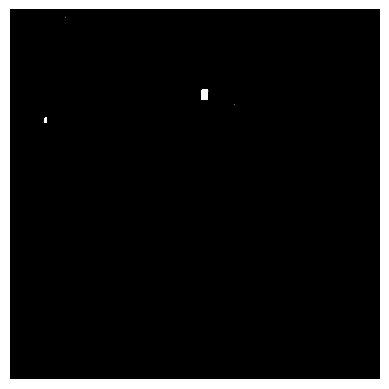

saving prediction image /content/Predicted_Images/996 OS-3.png


<ipython-input-55-63e61c211843>:7: UserWarning: /content/Predicted_Images/996 OS-3.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


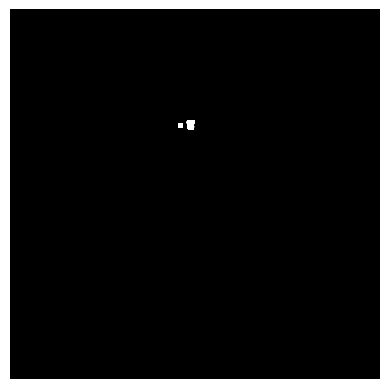

saving prediction image /content/Predicted_Images/275 OD-5.png


<ipython-input-55-63e61c211843>:7: UserWarning: /content/Predicted_Images/275 OD-5.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


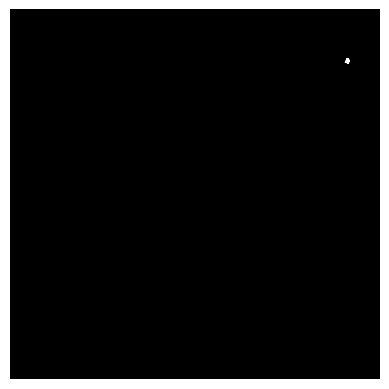

saving prediction image /content/Predicted_Images/480 OD-1.png


<ipython-input-55-63e61c211843>:7: UserWarning: /content/Predicted_Images/480 OD-1.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


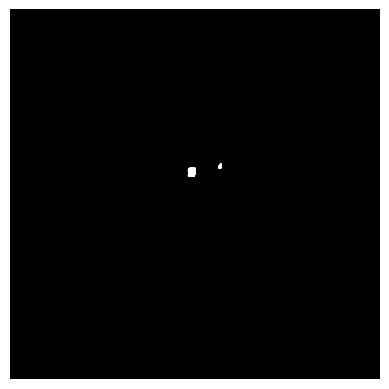

saving prediction image /content/Predicted_Images/694 OS-2.png


<ipython-input-55-63e61c211843>:7: UserWarning: /content/Predicted_Images/694 OS-2.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


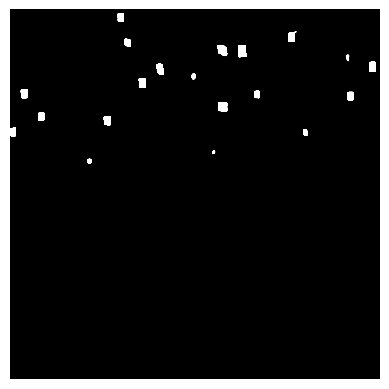

saving prediction image /content/Predicted_Images/152 OD-2.png


<ipython-input-55-63e61c211843>:7: UserWarning: /content/Predicted_Images/152 OD-2.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


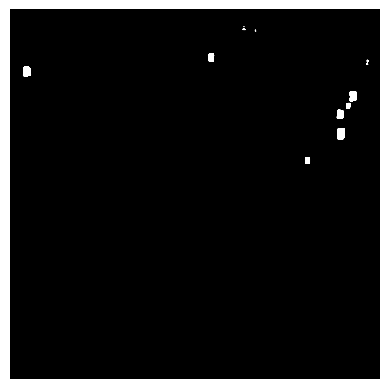

saving prediction image /content/Predicted_Images/966 OD-2.png


<ipython-input-55-63e61c211843>:7: UserWarning: /content/Predicted_Images/966 OD-2.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


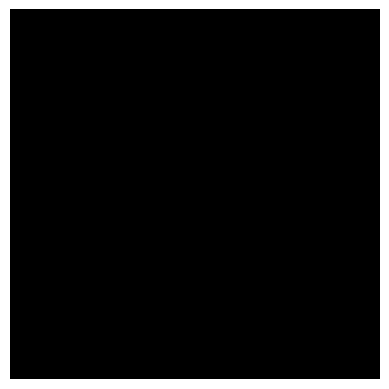

saving prediction image /content/Predicted_Images/152 OD-3.png


<ipython-input-55-63e61c211843>:7: UserWarning: /content/Predicted_Images/152 OD-3.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


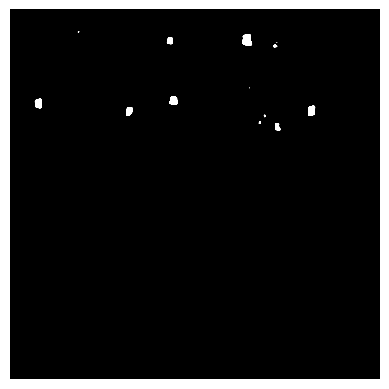

saving prediction image /content/Predicted_Images/24 OS-1.png


<ipython-input-55-63e61c211843>:7: UserWarning: /content/Predicted_Images/24 OS-1.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


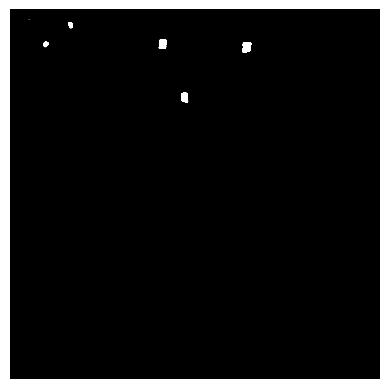

saving prediction image /content/Predicted_Images/694 OS-5.png


<ipython-input-55-63e61c211843>:7: UserWarning: /content/Predicted_Images/694 OS-5.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


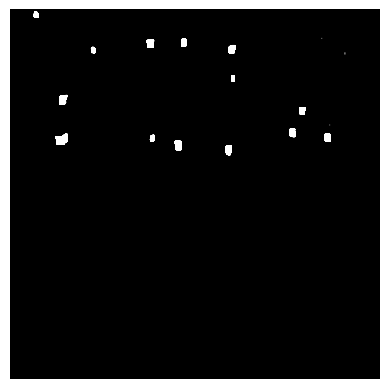

saving prediction image /content/Predicted_Images/2 OS-1.png


<ipython-input-55-63e61c211843>:7: UserWarning: /content/Predicted_Images/2 OS-1.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


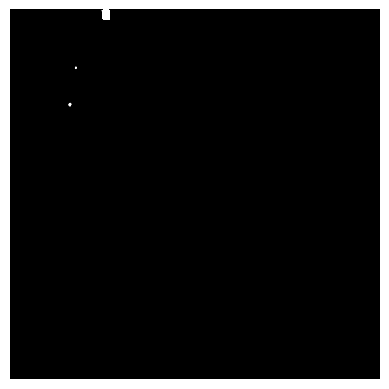

saving prediction image /content/Predicted_Images/480 OD-5.png


<ipython-input-55-63e61c211843>:7: UserWarning: /content/Predicted_Images/480 OD-5.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


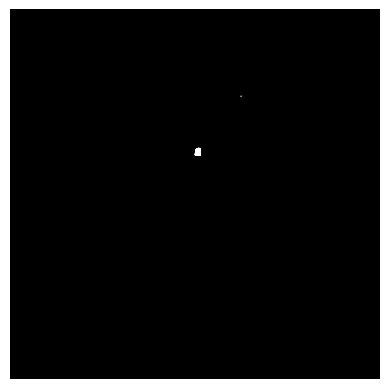

saving prediction image /content/Predicted_Images/152 OD-5.png


<ipython-input-55-63e61c211843>:7: UserWarning: /content/Predicted_Images/152 OD-5.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


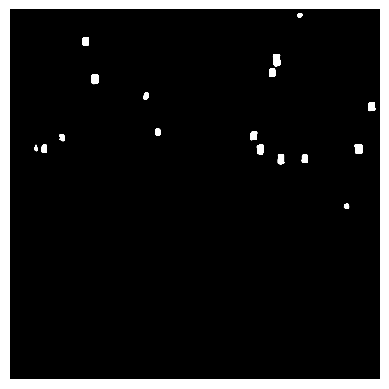

saving prediction image /content/Predicted_Images/694 OS-3.png


<ipython-input-55-63e61c211843>:7: UserWarning: /content/Predicted_Images/694 OS-3.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


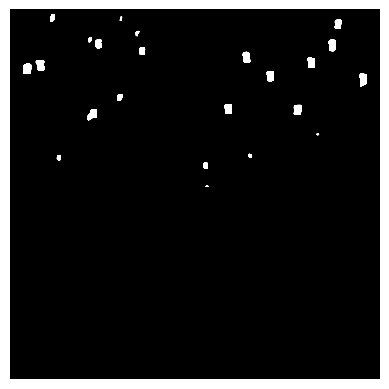

saving prediction image /content/Predicted_Images/152 OD-4.png


<ipython-input-55-63e61c211843>:7: UserWarning: /content/Predicted_Images/152 OD-4.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


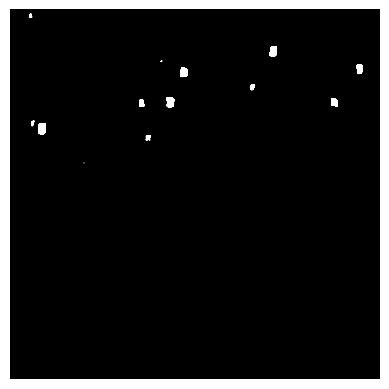

saving prediction image /content/Predicted_Images/357 OD-3.png


<ipython-input-55-63e61c211843>:7: UserWarning: /content/Predicted_Images/357 OD-3.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


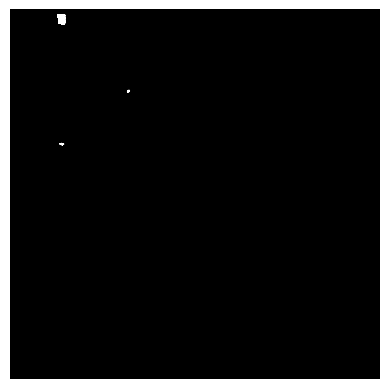

saving prediction image /content/Predicted_Images/357 OD-4.png


<ipython-input-55-63e61c211843>:7: UserWarning: /content/Predicted_Images/357 OD-4.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


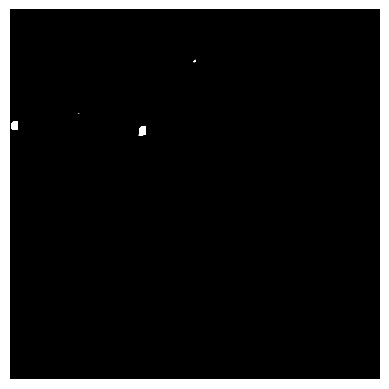

In [ ]:
# from skimage import io
# for i in range(pred.shape[0]):
#   prediction_image = (pred[i] * 255).astype(np.uint8)
#   prediction_image = np.squeeze(prediction_image)
#   output_path = test_image_paths[i].replace("Original_Images", "Predicted_Images")
#   print(f'saving prediction image {output_path}')
#   io.imsave(output_path, prediction_image, cmap='gray')

#   plt.imshow(prediction_image, cmap='gray', vmin=0, vmax=1)
#   plt.axis('off')
#   plt.show()

In [ ]:
! cp /content/Predicted_Images/*.png "/content/drive/.shortcut-targets-by-id/1Gd6Qvx67HvZr5HE48UMhRc2vhUfBl1Jh/PVO_Segmentation_Project/Processed_Images/aug24"

In [ ]:
# save the model so we can reload model
! cp /content/model_08_24_2023.pth "/content/drive/.shortcut-targets-by-id/1Gd6Qvx67HvZr5HE48UMhRc2vhUfBl1Jh/PVO_Segmentation_Project/Processed_Images/"

In the context of the ResNet architecture, layer4 typically refers to the last block of residual layers.

The output shape of (1, 512, 16, 16) indicates that you're extracting the feature maps after layer4 has processed the input.

The dimensions represent:
1: Batch size
512: Number of channels or feature maps
16x16: Spatial dimensions of the feature map
Given that the spatial dimensions are 16x16, this suggests that the input image has been downsampled by a factor of 16 in both height and width dimensions by the time it has passed through layer4. This is consistent with the typical behavior of ResNet architectures, which have several downsampling stages.

In [ ]:
import torch
import math
import numpy as np
from torchvision.utils import save_image

device = 'cpu'

#model = ResNetUNet()  # Define the model architecture
model.load_state_dict(torch.load('/content/model_08_24_2023.pth'))  # Load the weights
model.eval()

# Define the hook function
features_blobs = []
def hook_fn(module, input, output):
    features_blobs.append(output)


# Attach the hook to the desired layer
model.base_model.layer4.register_forward_hook(hook_fn)

# Create a new simulation dataset for testing
# test_dataset = SimDataset(3, transform = trans)
# test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, num_workers=0)
# Val batch size is the length of validation set
batch_size = len(test_image_paths)
print(batch_size)
dataloaders = {
  'val': torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)
}

# Get the first batch
inputs, masks =  next(iter(dataloaders['val']))
inputs = inputs.to(device)
labels = masks.to(device)
model = model.to(device)
print('inputs.shape', inputs[1].shape)
print('labels.shape', labels.shape)

# Predict
pred = model(inputs)
# The loss functions include the sigmoid function.
pred = torch.sigmoid(pred)
pred = pred.data.cpu().numpy()
inputs = inputs.data.cpu().numpy()
print('pred.shape', pred.shape)
print('pred.max', np.max(pred))

# Display and save the images
for i in range(pred.shape[0]):
    prediction_image = (pred[i] * 255).astype(np.uint8)
    prediction_image = np.squeeze(prediction_image)
    output_path = test_image_paths[i].replace("Original_Images", "Predicted_Images")
    print(f'saving prediction image {output_path}')
    io.imsave(output_path, prediction_image, cmap='gray')

    # Display the prediction image
    plt.imshow(prediction_image, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.show()

    # Display the low resolution image from the hook
    # Qestion: Taking the mean across channels for visualization
    low_res_image = features_blobs[i].squeeze().mean(0)
    plt.imshow(low_res_image, cmap='gray')
    plt.axis('off')
    plt.show()

71
inputs.shape torch.Size([3, 512, 512])
labels.shape torch.Size([71, 1, 512, 512])


**This section prints both prediction images and low resolution images obtained through a hook registered with the model**

saving prediction image /content/Predicted_Images/240 OD-4.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/240 OD-4.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


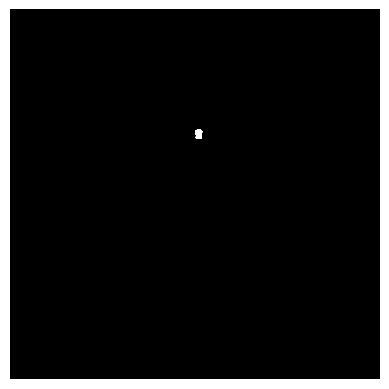

saving lowres image /content/Lowres_Images/240 OD-4.png


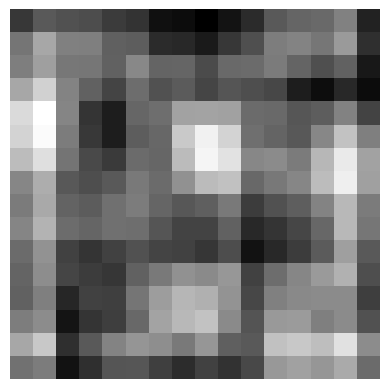

saving prediction image /content/Predicted_Images/690 OS-1.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/690 OS-1.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


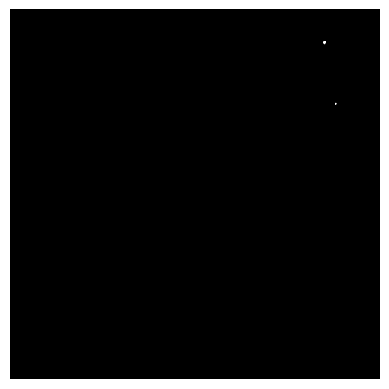

saving lowres image /content/Lowres_Images/690 OS-1.png


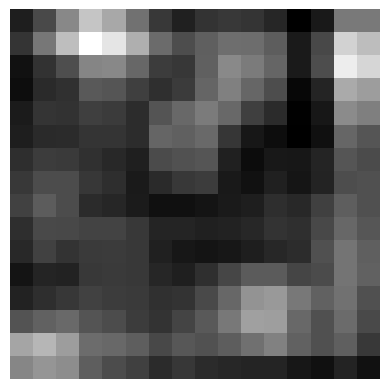

saving prediction image /content/Predicted_Images/45 OS-5.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/45 OS-5.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


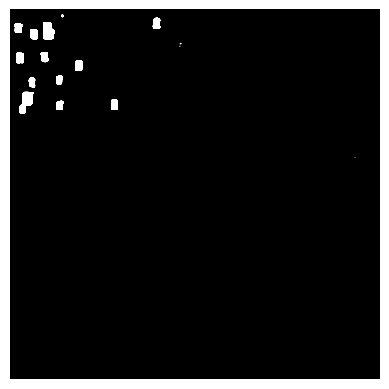

saving lowres image /content/Lowres_Images/45 OS-5.png


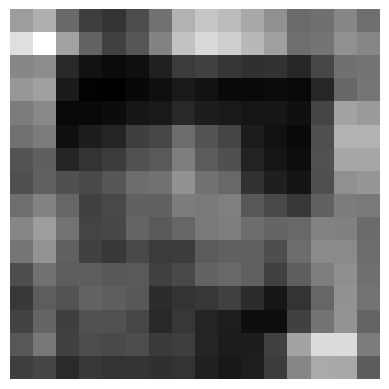

saving prediction image /content/Predicted_Images/152 OD-5.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/152 OD-5.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


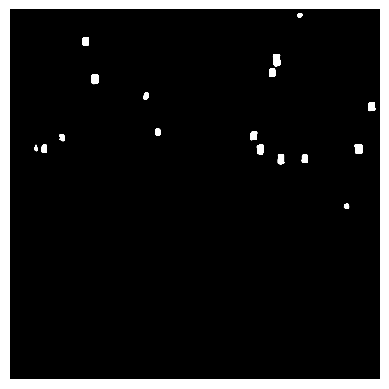

saving lowres image /content/Lowres_Images/152 OD-5.png


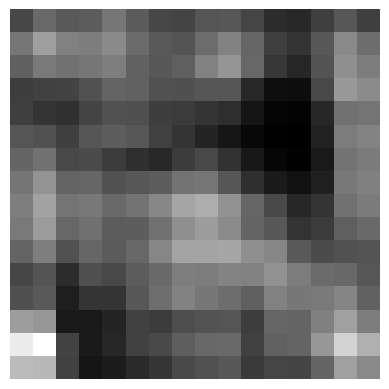

saving prediction image /content/Predicted_Images/45 OS-2.png


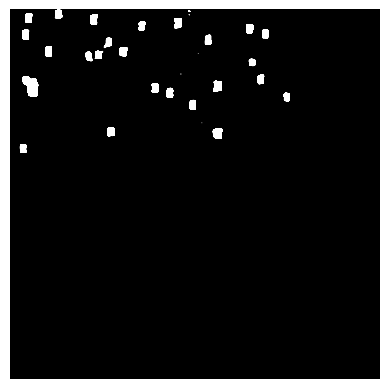

saving lowres image /content/Lowres_Images/45 OS-2.png


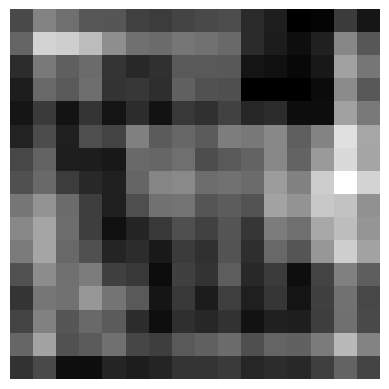

saving prediction image /content/Predicted_Images/275 OD-5.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/275 OD-5.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


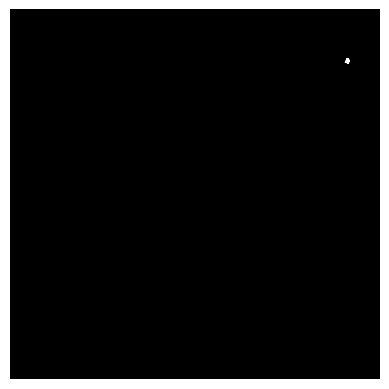

saving lowres image /content/Lowres_Images/275 OD-5.png


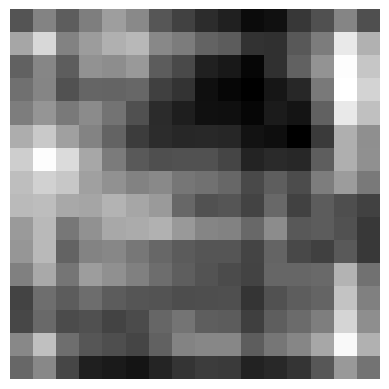

saving prediction image /content/Predicted_Images/483 OS-2.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/483 OS-2.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


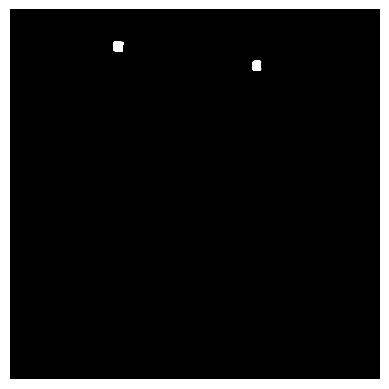

saving lowres image /content/Lowres_Images/483 OS-2.png


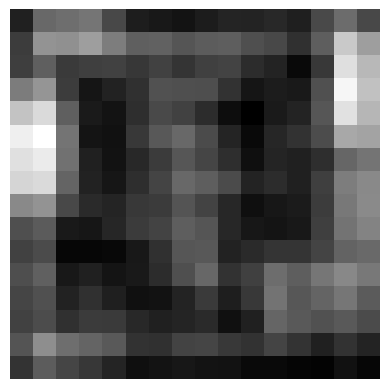

saving prediction image /content/Predicted_Images/357 OD-4.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/357 OD-4.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


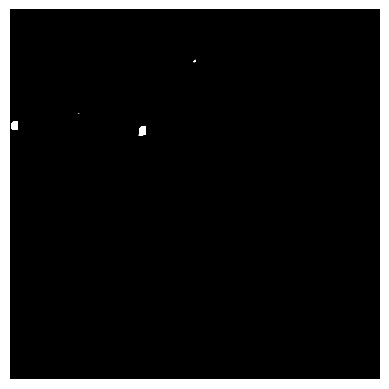

saving lowres image /content/Lowres_Images/357 OD-4.png


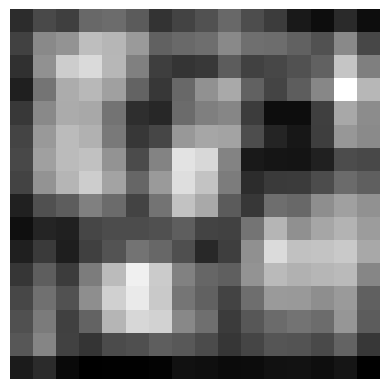

saving prediction image /content/Predicted_Images/966 OD-1.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/966 OD-1.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


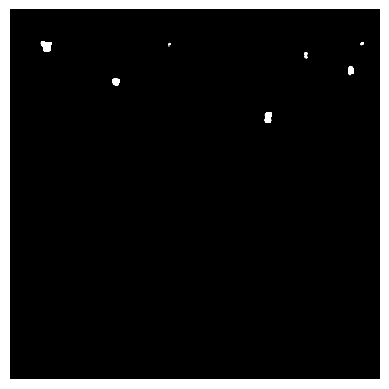

saving lowres image /content/Lowres_Images/966 OD-1.png


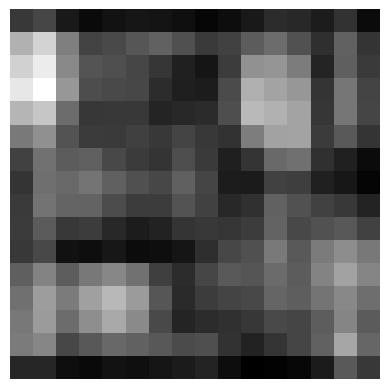

saving prediction image /content/Predicted_Images/24 OS-4.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/24 OS-4.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


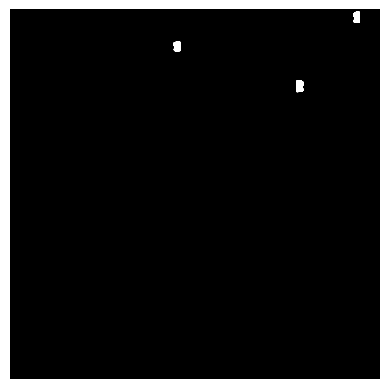

saving lowres image /content/Lowres_Images/24 OS-4.png


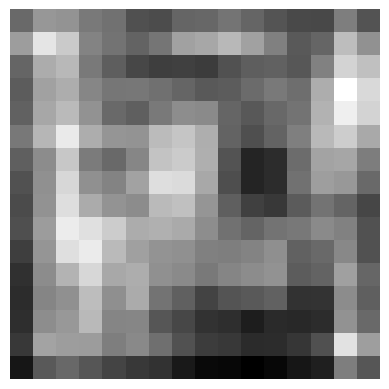

saving prediction image /content/Predicted_Images/152 OD-2.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/152 OD-2.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


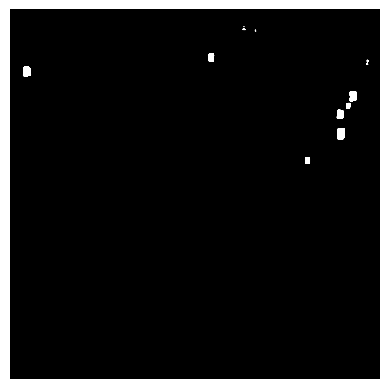

saving lowres image /content/Lowres_Images/152 OD-2.png


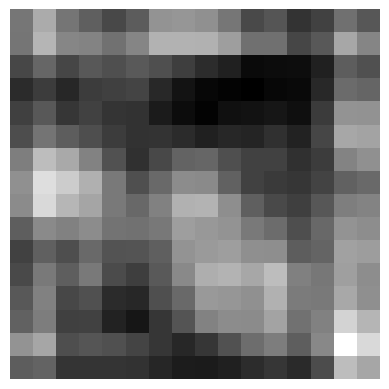

saving prediction image /content/Predicted_Images/694 OS-3.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/694 OS-3.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


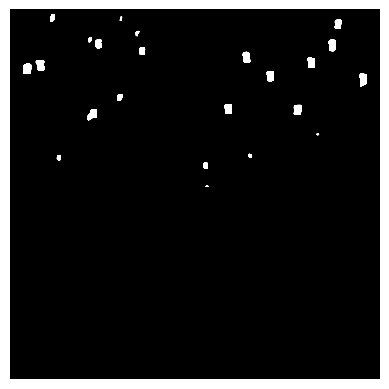

saving lowres image /content/Lowres_Images/694 OS-3.png


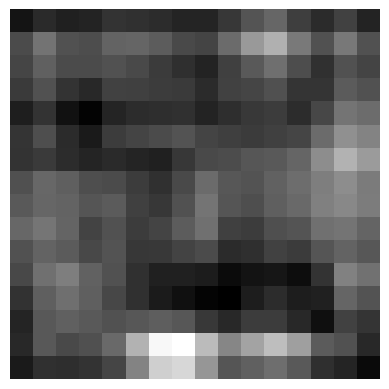

saving prediction image /content/Predicted_Images/240 OD-5.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/240 OD-5.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


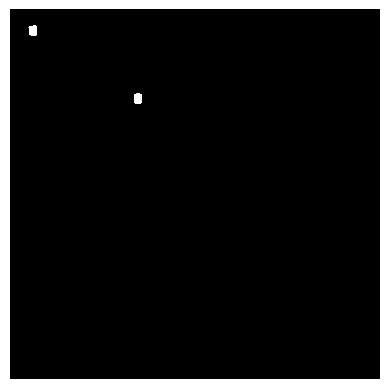

saving lowres image /content/Lowres_Images/240 OD-5.png


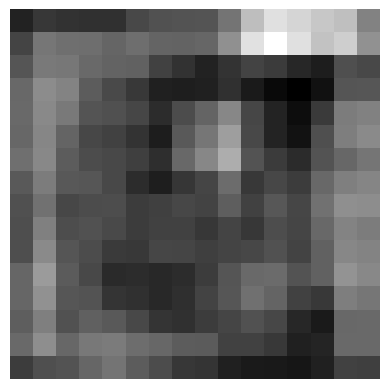

saving prediction image /content/Predicted_Images/261 OD-2.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/261 OD-2.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


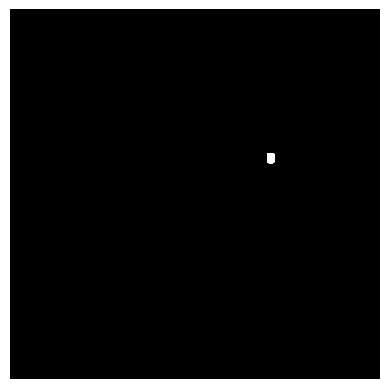

saving lowres image /content/Lowres_Images/261 OD-2.png


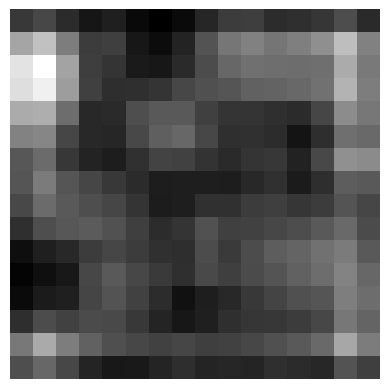

saving prediction image /content/Predicted_Images/1 OS-4.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/1 OS-4.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


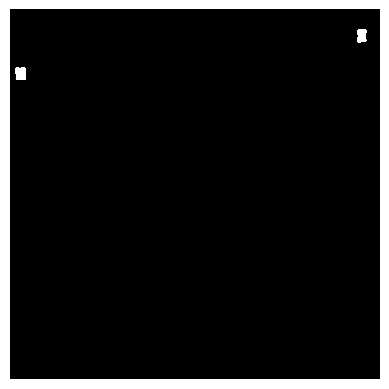

saving lowres image /content/Lowres_Images/1 OS-4.png


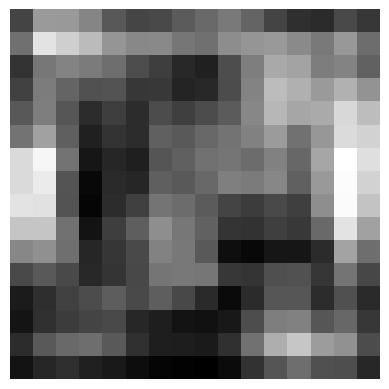

saving prediction image /content/Predicted_Images/357 OD-3.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/357 OD-3.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


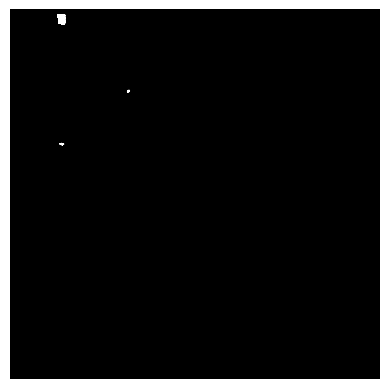

saving lowres image /content/Lowres_Images/357 OD-3.png


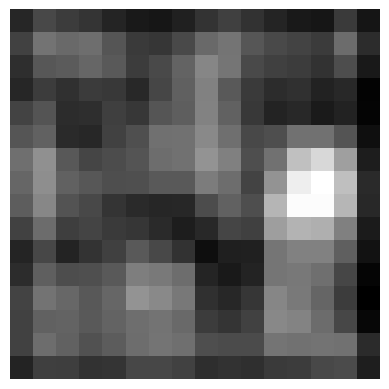

saving prediction image /content/Predicted_Images/480 OD-3.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/480 OD-3.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


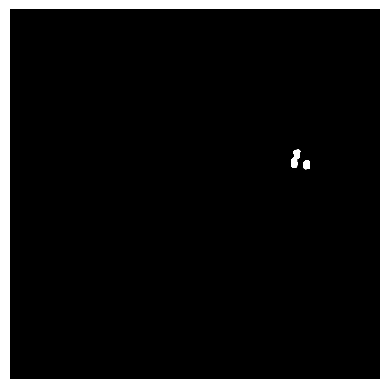

saving lowres image /content/Lowres_Images/480 OD-3.png


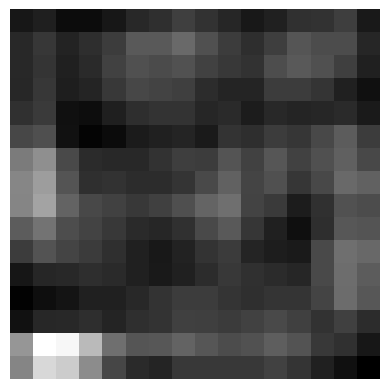

saving prediction image /content/Predicted_Images/261 OD-3.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/261 OD-3.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


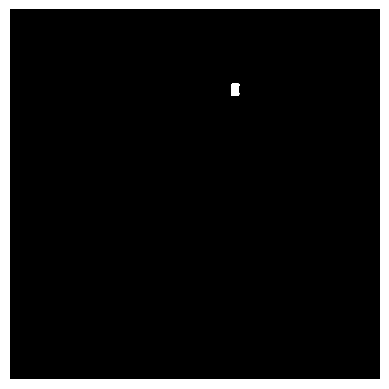

saving lowres image /content/Lowres_Images/261 OD-3.png


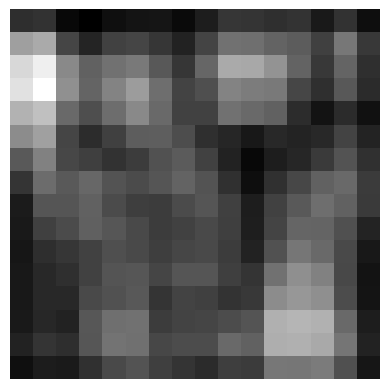

saving prediction image /content/Predicted_Images/352 OS-1.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/352 OS-1.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


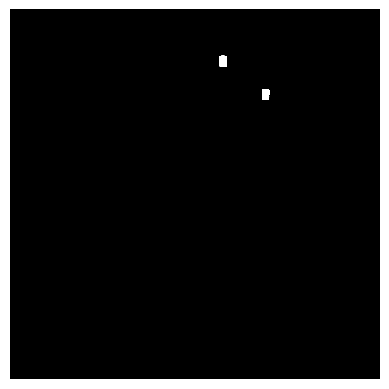

saving lowres image /content/Lowres_Images/352 OS-1.png


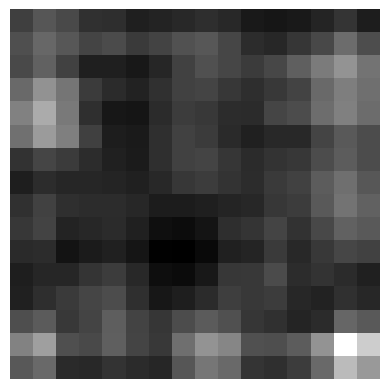

saving prediction image /content/Predicted_Images/24 OS-1.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/24 OS-1.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


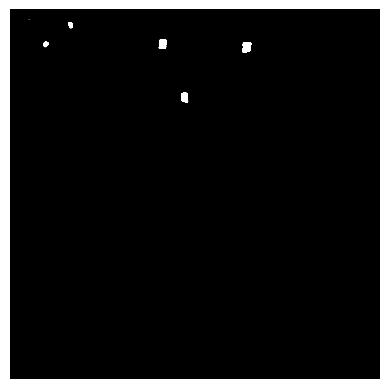

saving lowres image /content/Lowres_Images/24 OS-1.png


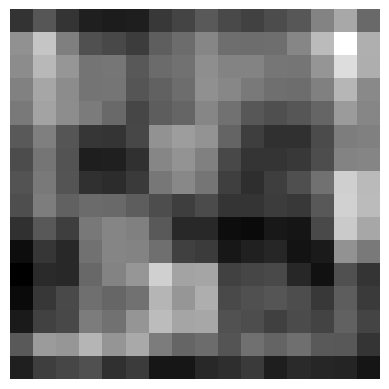

saving prediction image /content/Predicted_Images/45 OS-3.png


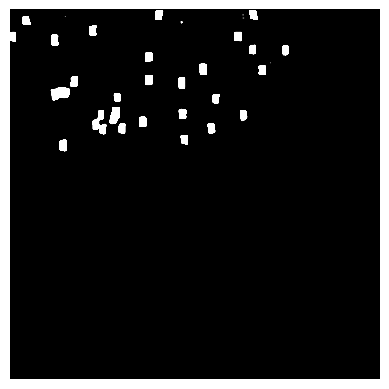

saving lowres image /content/Lowres_Images/45 OS-3.png


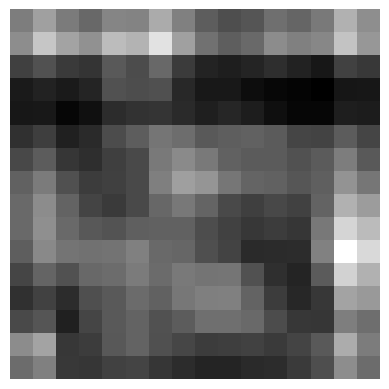

saving prediction image /content/Predicted_Images/2 OS-5.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/2 OS-5.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


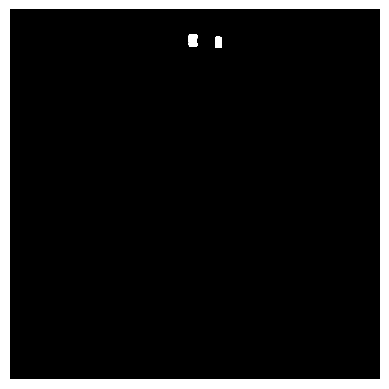

saving lowres image /content/Lowres_Images/2 OS-5.png


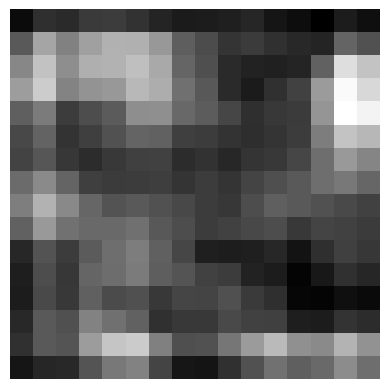

saving prediction image /content/Predicted_Images/694 OS-2.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/694 OS-2.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


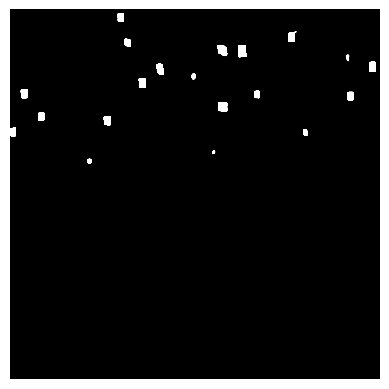

saving lowres image /content/Lowres_Images/694 OS-2.png


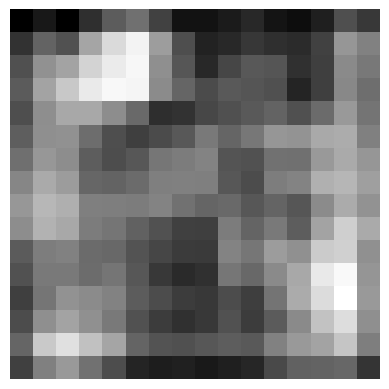

saving prediction image /content/Predicted_Images/152 OD-4.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/152 OD-4.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


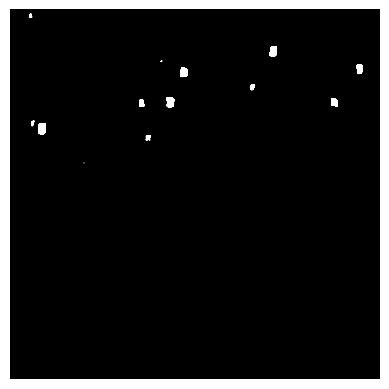

saving lowres image /content/Lowres_Images/152 OD-4.png


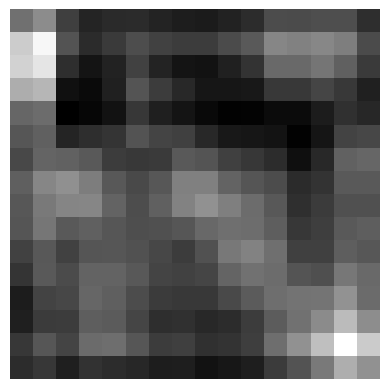

saving prediction image /content/Predicted_Images/152 OD-3.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/152 OD-3.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


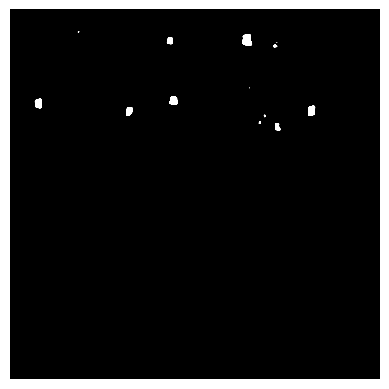

saving lowres image /content/Lowres_Images/152 OD-3.png


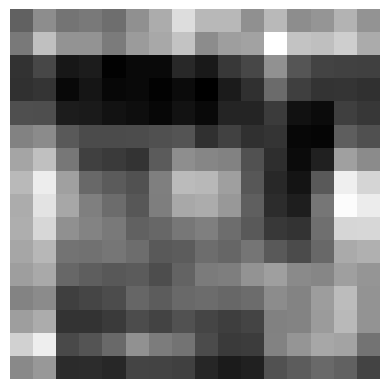

saving prediction image /content/Predicted_Images/399 OD-1.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/399 OD-1.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


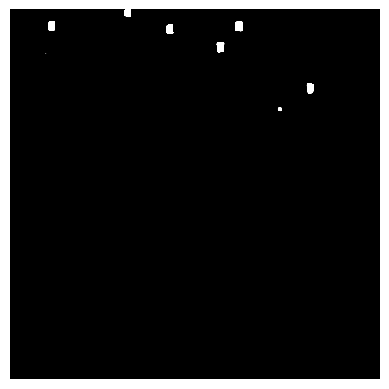

saving lowres image /content/Lowres_Images/399 OD-1.png


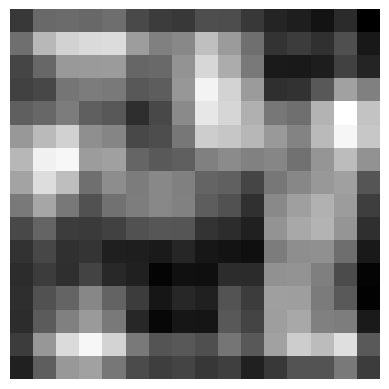

saving prediction image /content/Predicted_Images/399 OD-3.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/399 OD-3.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


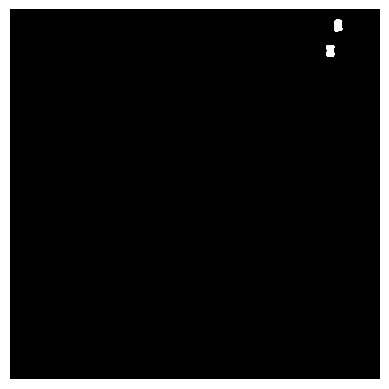

saving lowres image /content/Lowres_Images/399 OD-3.png


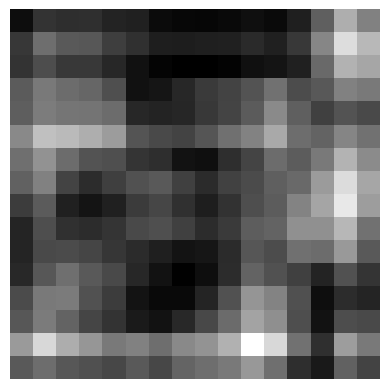

saving prediction image /content/Predicted_Images/45 OS-4.png


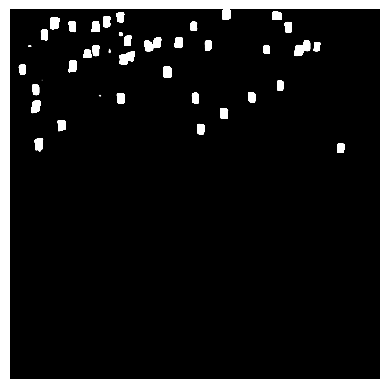

saving lowres image /content/Lowres_Images/45 OS-4.png


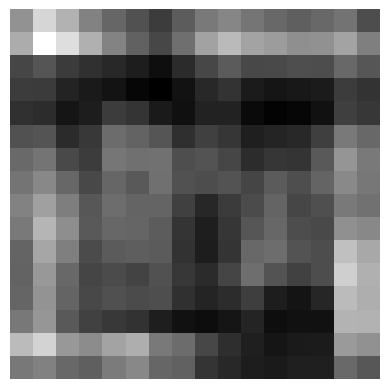

saving prediction image /content/Predicted_Images/24 OS-3.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/24 OS-3.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


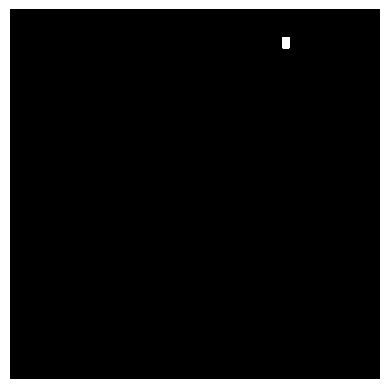

saving lowres image /content/Lowres_Images/24 OS-3.png


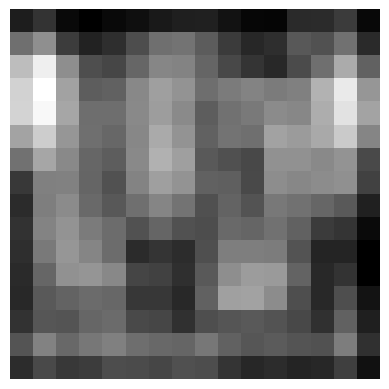

saving prediction image /content/Predicted_Images/223 OS-2.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/223 OS-2.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


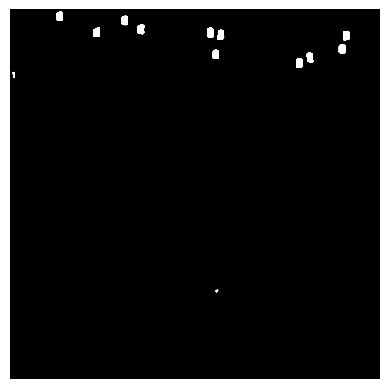

saving lowres image /content/Lowres_Images/223 OS-2.png


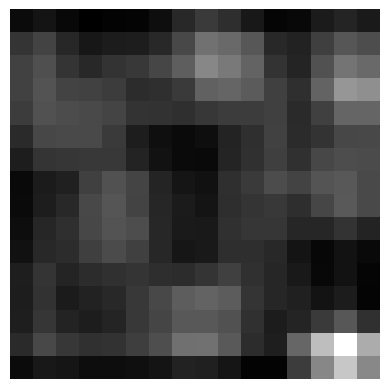

saving prediction image /content/Predicted_Images/2 OS-1.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/2 OS-1.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


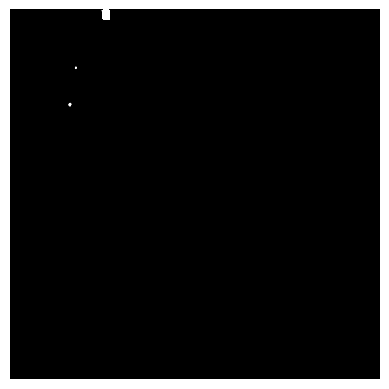

saving lowres image /content/Lowres_Images/2 OS-1.png


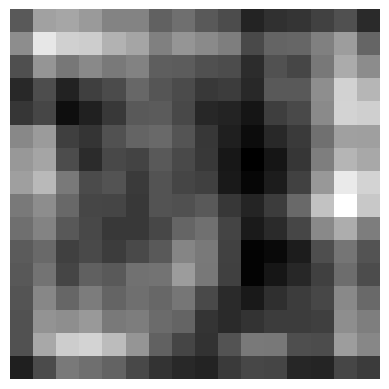

saving prediction image /content/Predicted_Images/966 OD-3.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/966 OD-3.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


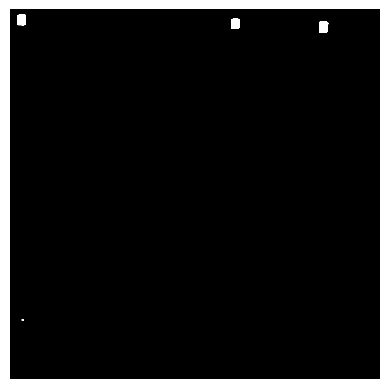

saving lowres image /content/Lowres_Images/966 OD-3.png


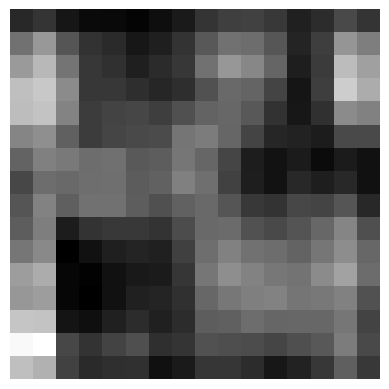

saving prediction image /content/Predicted_Images/694 OS-1.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/694 OS-1.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


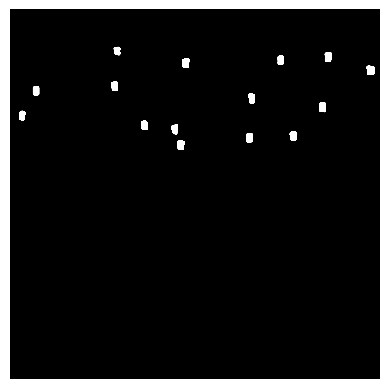

saving lowres image /content/Lowres_Images/694 OS-1.png


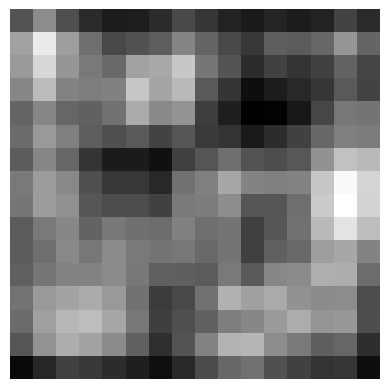

saving prediction image /content/Predicted_Images/966 OD-4.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/966 OD-4.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


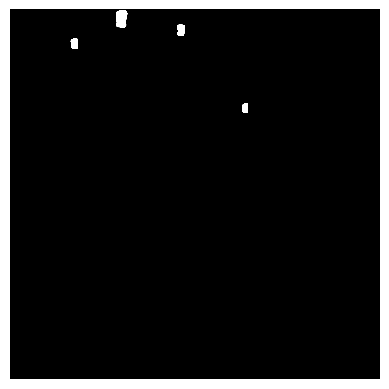

saving lowres image /content/Lowres_Images/966 OD-4.png


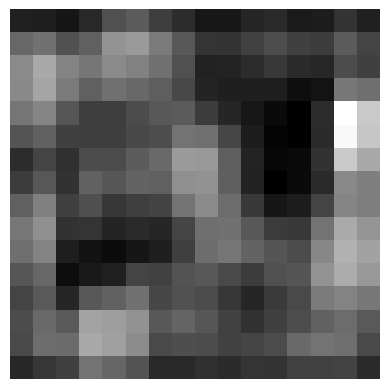

saving prediction image /content/Predicted_Images/223 OS-4.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/223 OS-4.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


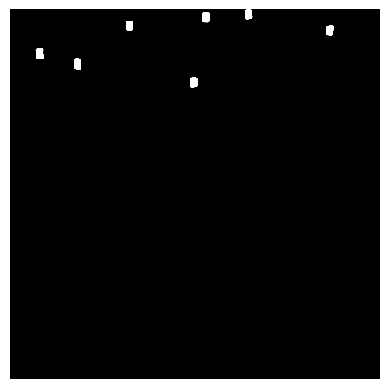

saving lowres image /content/Lowres_Images/223 OS-4.png


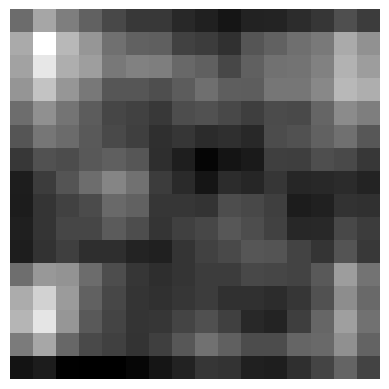

saving prediction image /content/Predicted_Images/24 OS-5.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/24 OS-5.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


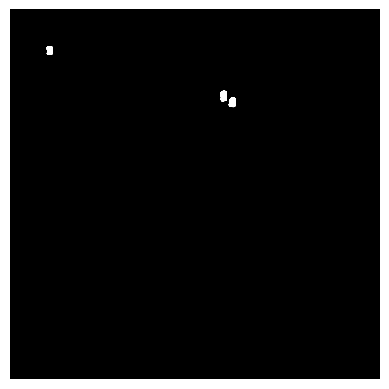

saving lowres image /content/Lowres_Images/24 OS-5.png


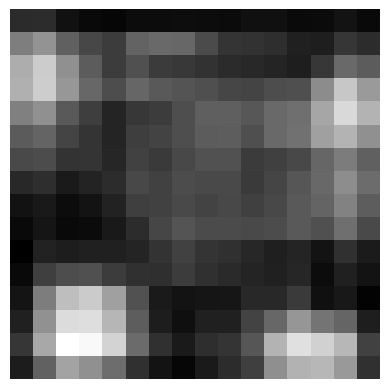

saving prediction image /content/Predicted_Images/319 OD-3.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/319 OD-3.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


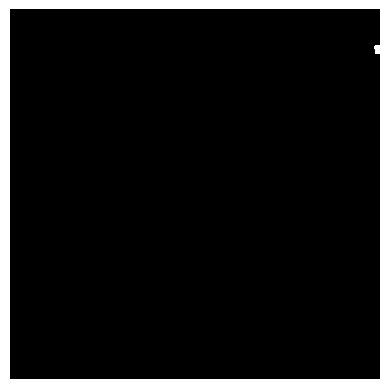

saving lowres image /content/Lowres_Images/319 OD-3.png


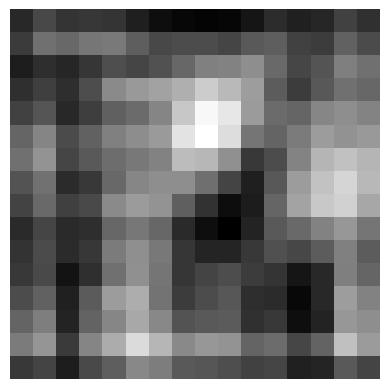

saving prediction image /content/Predicted_Images/399 OD-2.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/399 OD-2.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


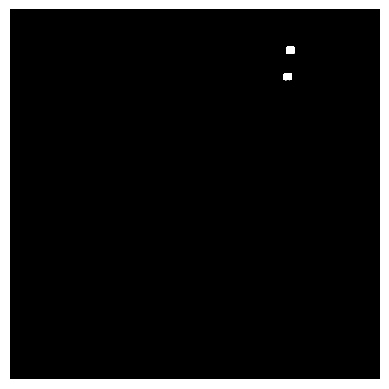

saving lowres image /content/Lowres_Images/399 OD-2.png


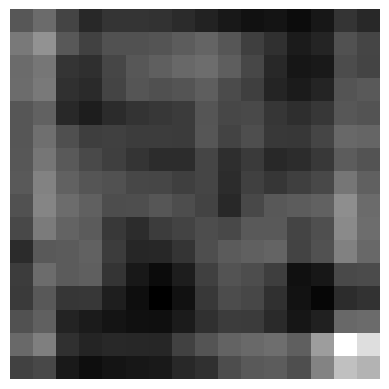

saving prediction image /content/Predicted_Images/24 OS-2.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/24 OS-2.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


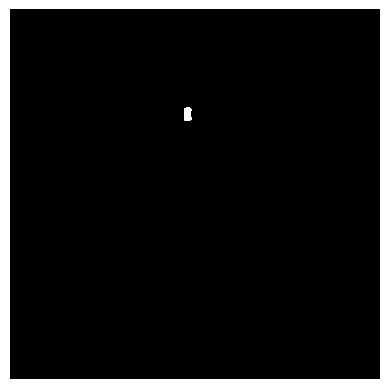

saving lowres image /content/Lowres_Images/24 OS-2.png


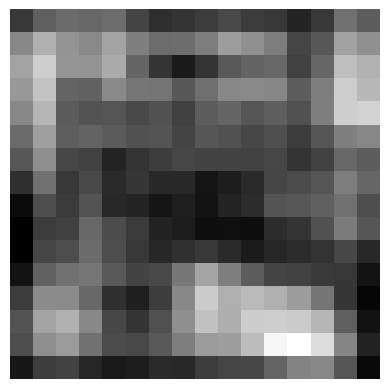

saving prediction image /content/Predicted_Images/996 OS-3.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/996 OS-3.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


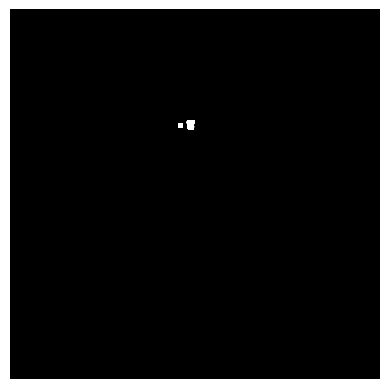

saving lowres image /content/Lowres_Images/996 OS-3.png


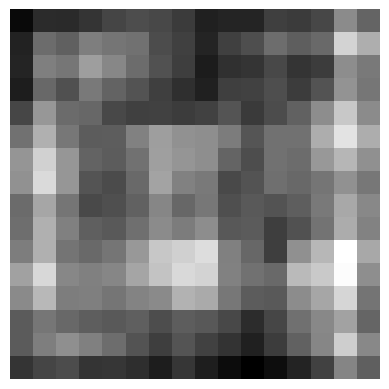

saving prediction image /content/Predicted_Images/480 OD-5.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/480 OD-5.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


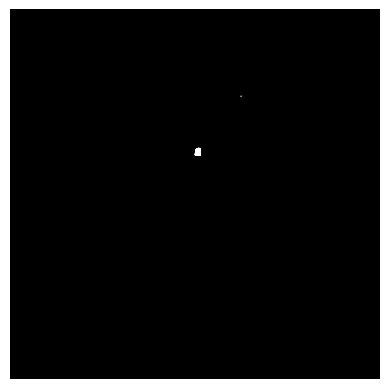

saving lowres image /content/Lowres_Images/480 OD-5.png


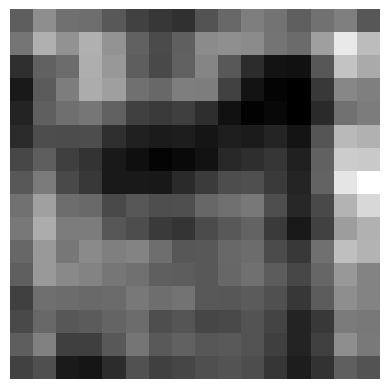

saving prediction image /content/Predicted_Images/399 OD-4.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/399 OD-4.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


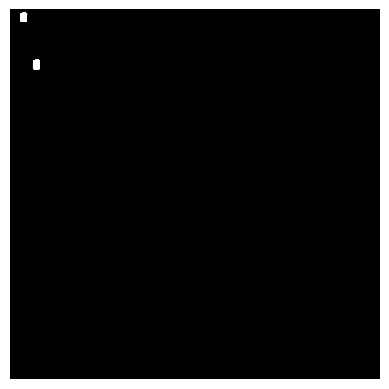

saving lowres image /content/Lowres_Images/399 OD-4.png


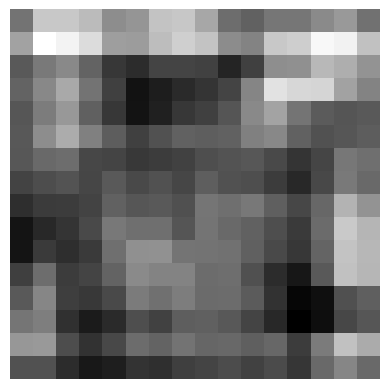

saving prediction image /content/Predicted_Images/352 OS-4.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/352 OS-4.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


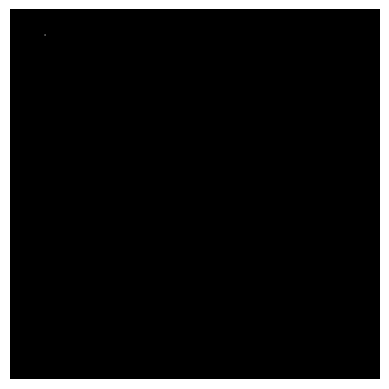

saving lowres image /content/Lowres_Images/352 OS-4.png


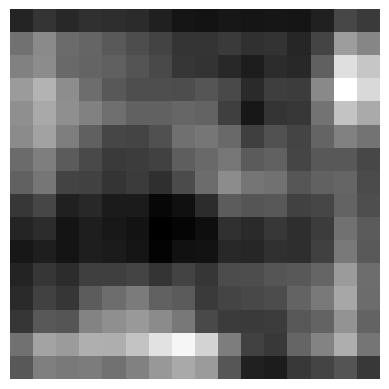

saving prediction image /content/Predicted_Images/357 OD-1.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/357 OD-1.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


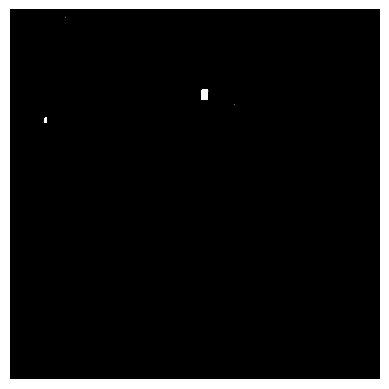

saving lowres image /content/Lowres_Images/357 OD-1.png


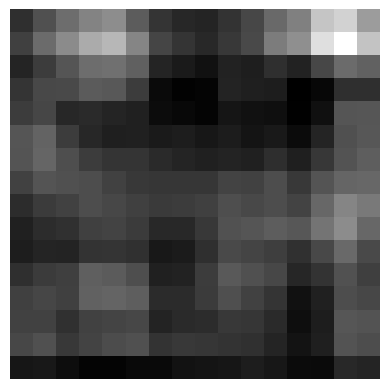

saving prediction image /content/Predicted_Images/399 OD-5.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/399 OD-5.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


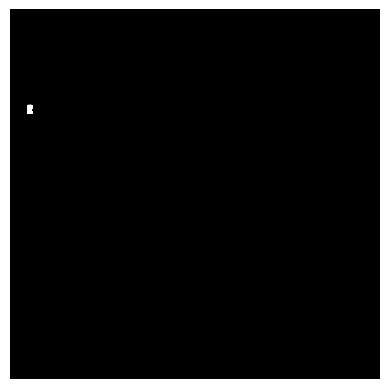

saving lowres image /content/Lowres_Images/399 OD-5.png


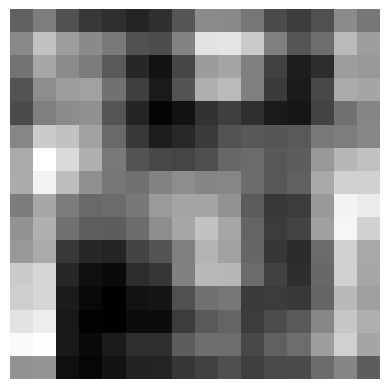

saving prediction image /content/Predicted_Images/267 OS-1.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/267 OS-1.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


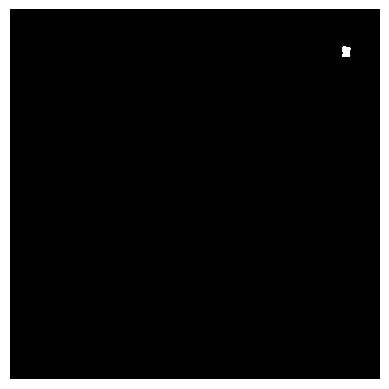

saving lowres image /content/Lowres_Images/267 OS-1.png


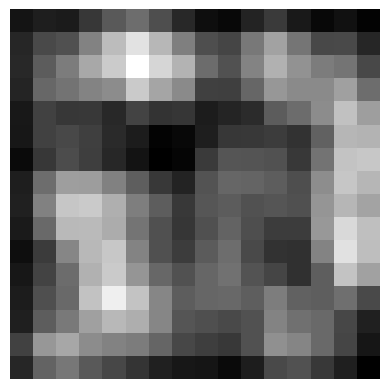

saving prediction image /content/Predicted_Images/694 OS-4.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/694 OS-4.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


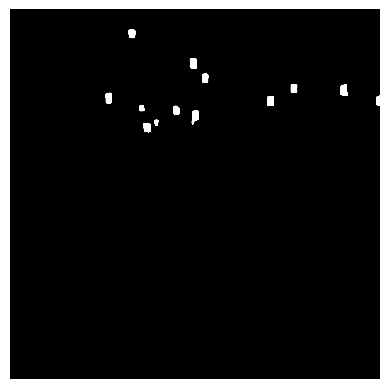

saving lowres image /content/Lowres_Images/694 OS-4.png


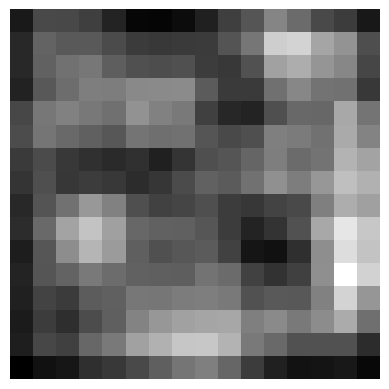

saving prediction image /content/Predicted_Images/694 OS-5.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/694 OS-5.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


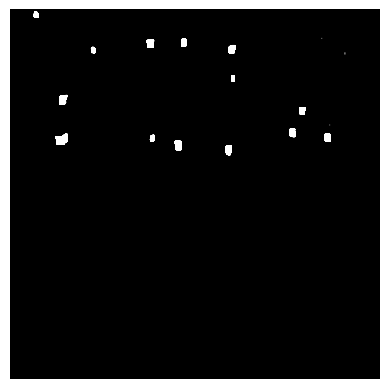

saving lowres image /content/Lowres_Images/694 OS-5.png


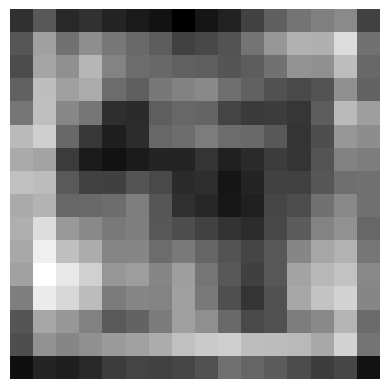

saving prediction image /content/Predicted_Images/1 OS-1.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/1 OS-1.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


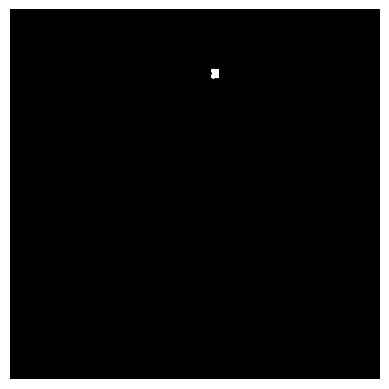

saving lowres image /content/Lowres_Images/1 OS-1.png


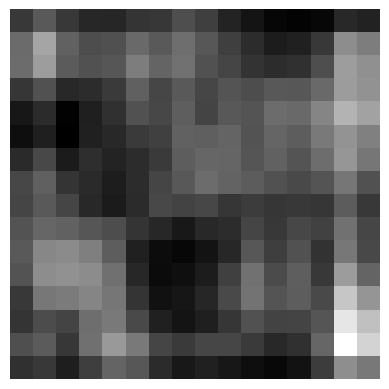

saving prediction image /content/Predicted_Images/934 OD-3.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/934 OD-3.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


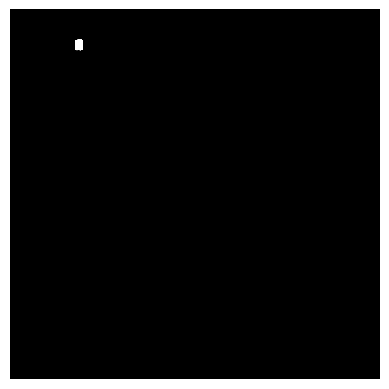

saving lowres image /content/Lowres_Images/934 OD-3.png


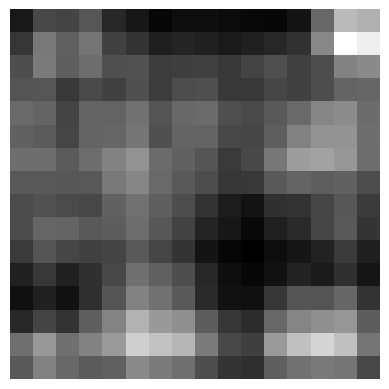

saving prediction image /content/Predicted_Images/261 OD-1.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/261 OD-1.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


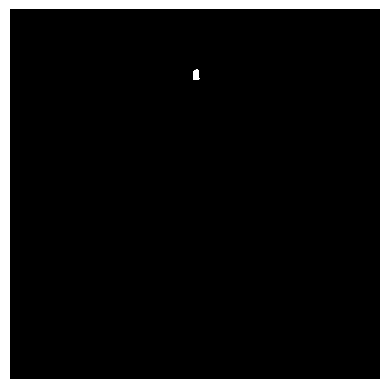

saving lowres image /content/Lowres_Images/261 OD-1.png


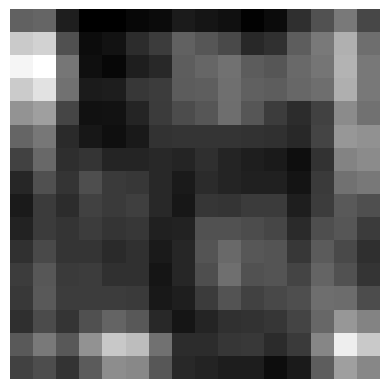

saving prediction image /content/Predicted_Images/966 OD-2.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/966 OD-2.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


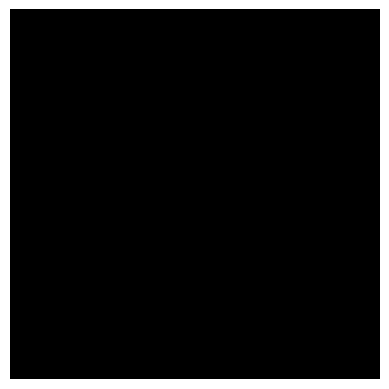

saving lowres image /content/Lowres_Images/966 OD-2.png


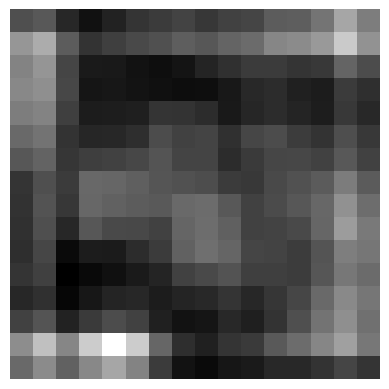

saving prediction image /content/Predicted_Images/223 OS-3.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/223 OS-3.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


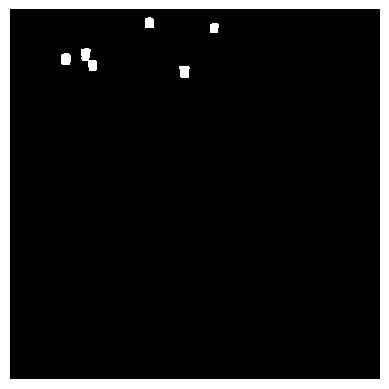

saving lowres image /content/Lowres_Images/223 OS-3.png


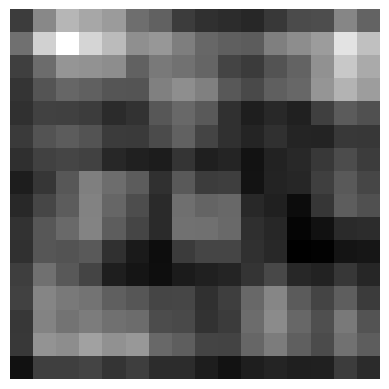

saving prediction image /content/Predicted_Images/2 OS-4.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/2 OS-4.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


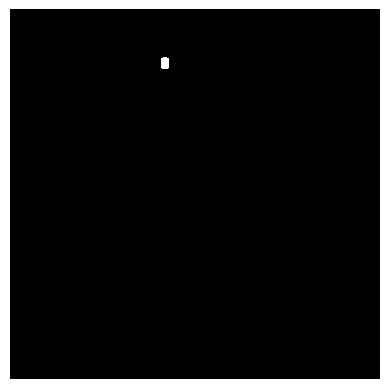

saving lowres image /content/Lowres_Images/2 OS-4.png


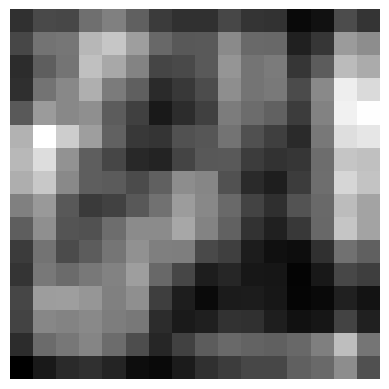

saving prediction image /content/Predicted_Images/267 OS-3.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/267 OS-3.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


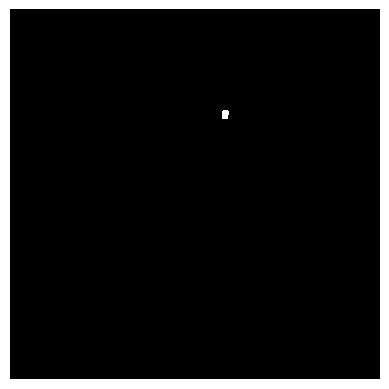

saving lowres image /content/Lowres_Images/267 OS-3.png


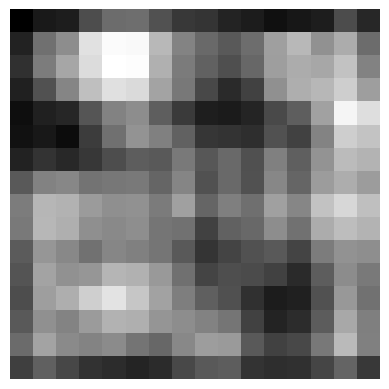

saving prediction image /content/Predicted_Images/45 OS-1.png


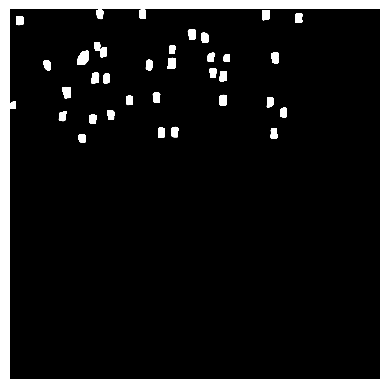

saving lowres image /content/Lowres_Images/45 OS-1.png


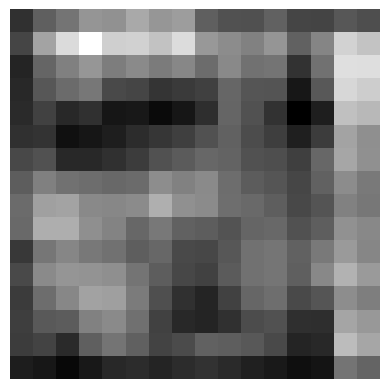

saving prediction image /content/Predicted_Images/934 OD-1.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/934 OD-1.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


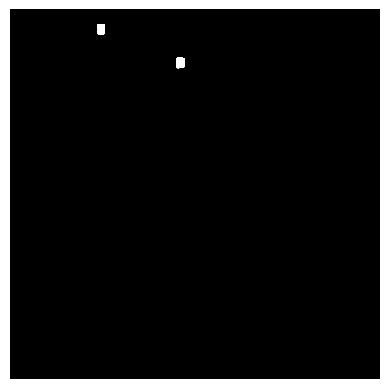

saving lowres image /content/Lowres_Images/934 OD-1.png


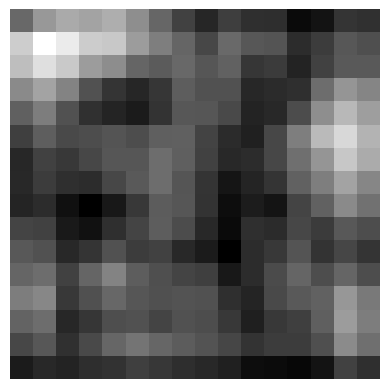

saving prediction image /content/Predicted_Images/480 OD-4.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/480 OD-4.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


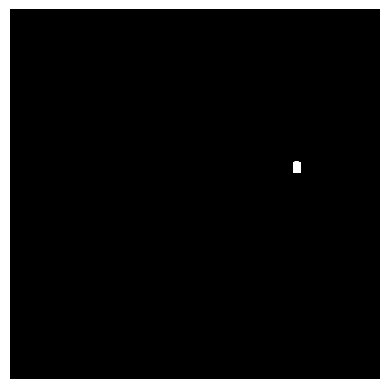

saving lowres image /content/Lowres_Images/480 OD-4.png


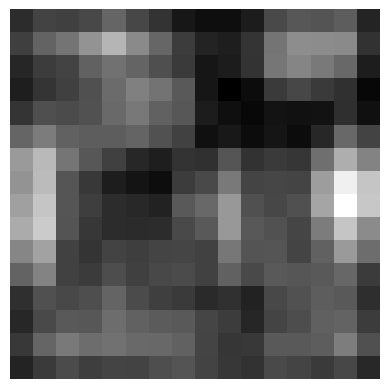

saving prediction image /content/Predicted_Images/223 OS-1.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/223 OS-1.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


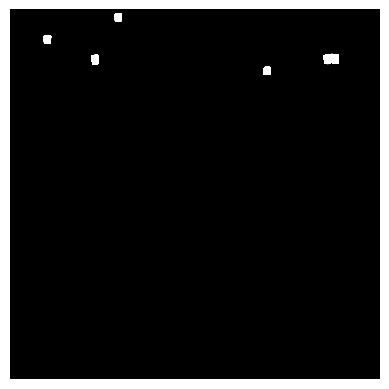

saving lowres image /content/Lowres_Images/223 OS-1.png


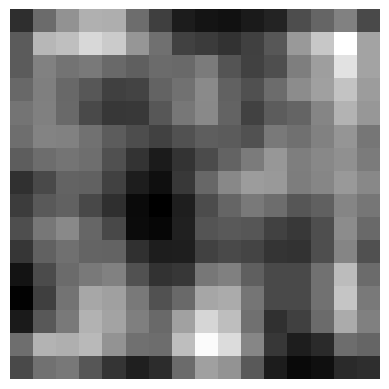

saving prediction image /content/Predicted_Images/261 OD-5.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/261 OD-5.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


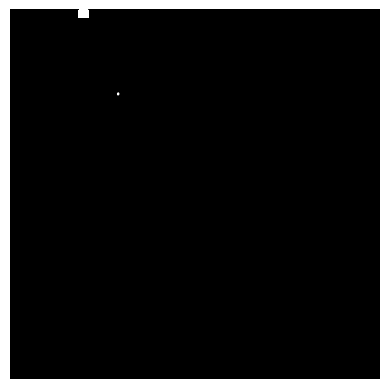

saving lowres image /content/Lowres_Images/261 OD-5.png


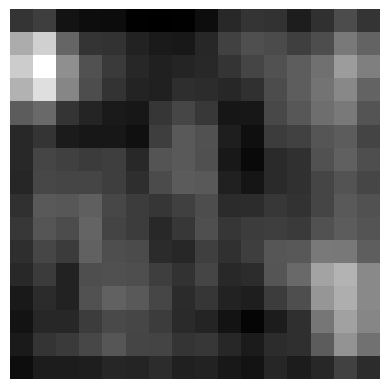

saving prediction image /content/Predicted_Images/275 OD-3.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/275 OD-3.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


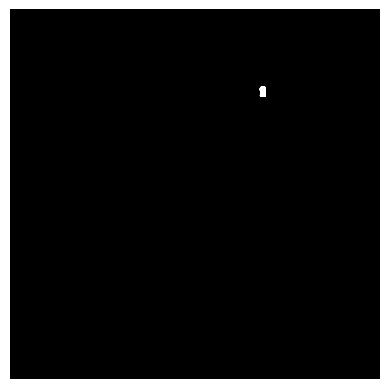

saving lowres image /content/Lowres_Images/275 OD-3.png


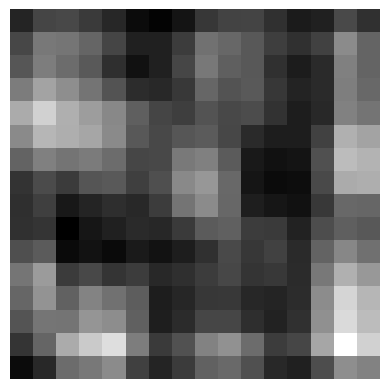

saving prediction image /content/Predicted_Images/480 OD-1.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/480 OD-1.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


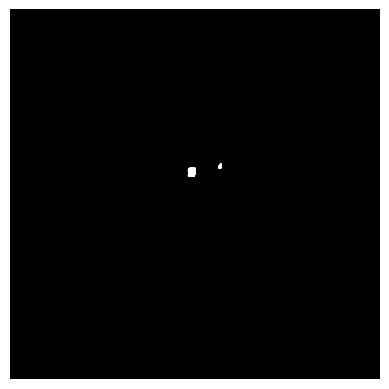

saving lowres image /content/Lowres_Images/480 OD-1.png


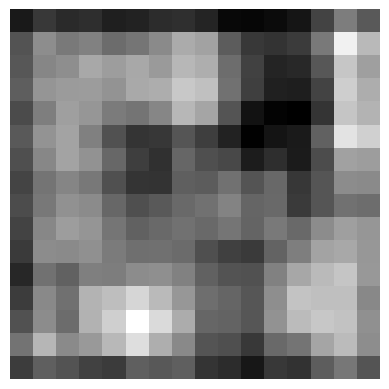

saving prediction image /content/Predicted_Images/2 OS-2.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/2 OS-2.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


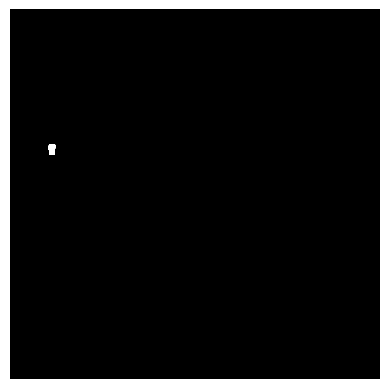

saving lowres image /content/Lowres_Images/2 OS-2.png


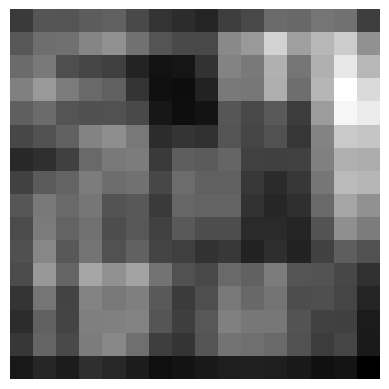

saving prediction image /content/Predicted_Images/483 OS-5.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/483 OS-5.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


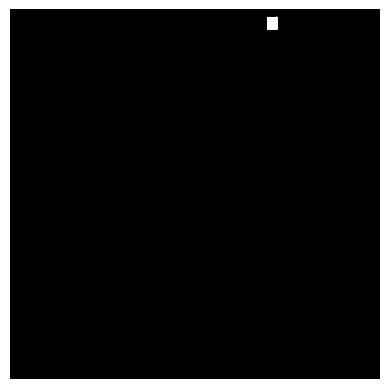

saving lowres image /content/Lowres_Images/483 OS-5.png


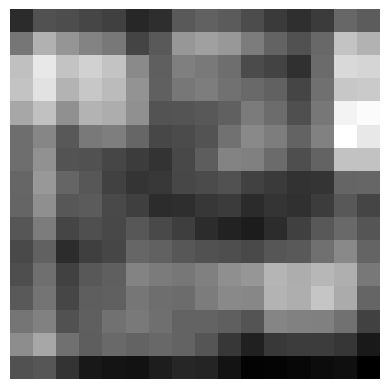

saving prediction image /content/Predicted_Images/934 OD-5.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/934 OD-5.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


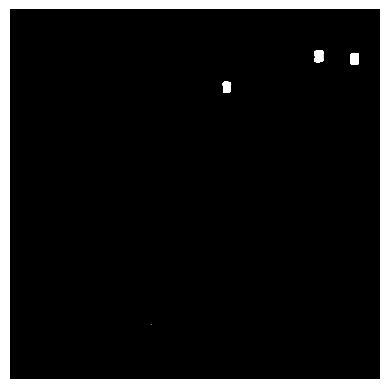

saving lowres image /content/Lowres_Images/934 OD-5.png


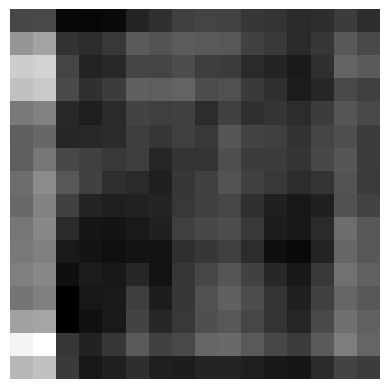

saving prediction image /content/Predicted_Images/966 OD-5.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/966 OD-5.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


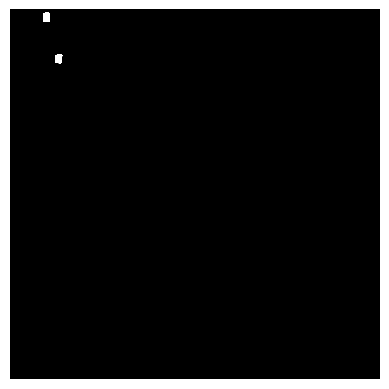

saving lowres image /content/Lowres_Images/966 OD-5.png


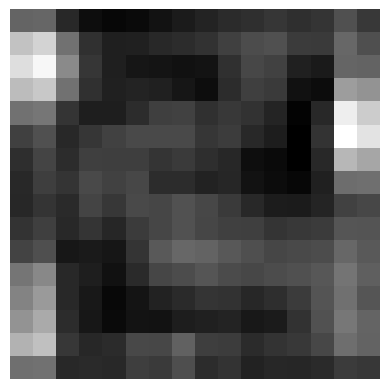

saving prediction image /content/Predicted_Images/152 OD-1.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/152 OD-1.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


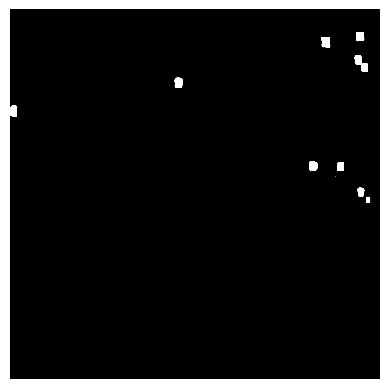

saving lowres image /content/Lowres_Images/152 OD-1.png


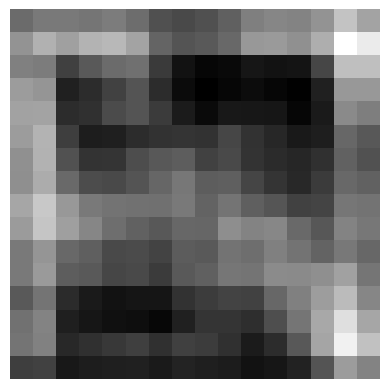

saving prediction image /content/Predicted_Images/267 OS-4.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/267 OS-4.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


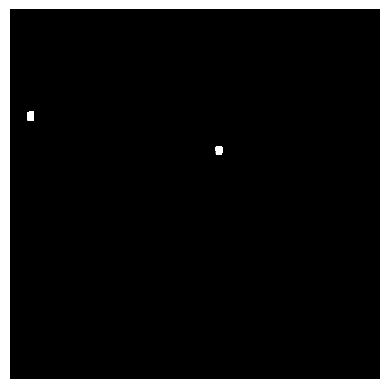

saving lowres image /content/Lowres_Images/267 OS-4.png


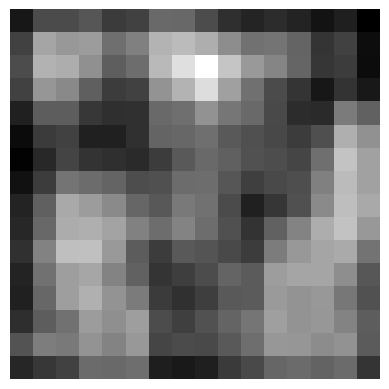

saving prediction image /content/Predicted_Images/223 OS-5.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/223 OS-5.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


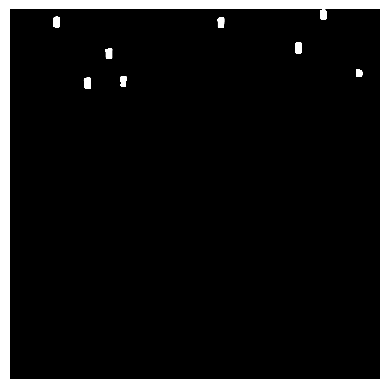

saving lowres image /content/Lowres_Images/223 OS-5.png


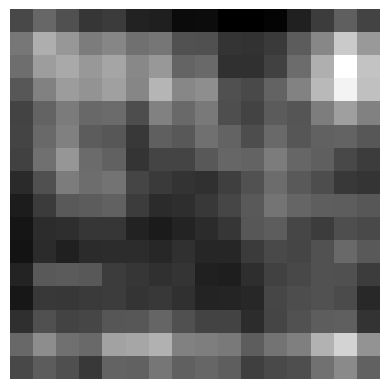

saving prediction image /content/Predicted_Images/934 OD-2.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/934 OD-2.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


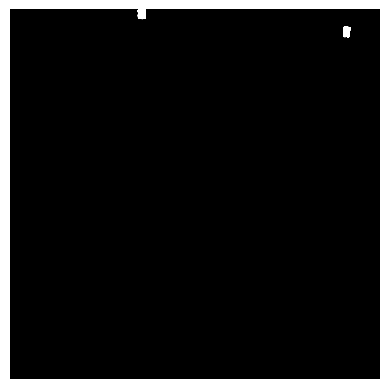

saving lowres image /content/Lowres_Images/934 OD-2.png


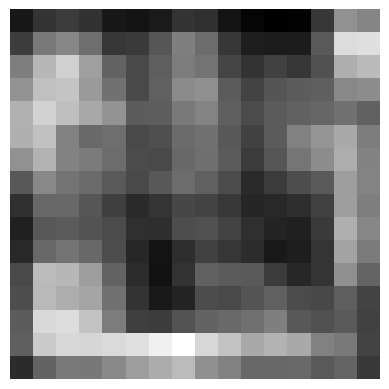

saving prediction image /content/Predicted_Images/5 OS-2.png


<ipython-input-26-a4ad3a36c087>:41: UserWarning: /content/Predicted_Images/5 OS-2.png is a low contrast image
  io.imsave(output_path, prediction_image, cmap='gray')


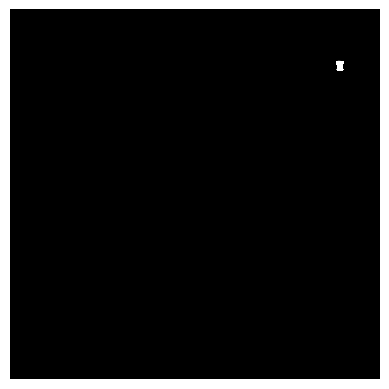

saving lowres image /content/Lowres_Images/5 OS-2.png


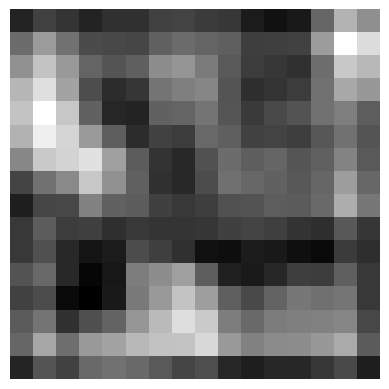

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

device = 'cpu'

# Load the model weights
model.load_state_dict(torch.load('/content/model_08_24_2023.pth'))
model.eval()

# Define the hook function
features_blobs = []
def hook_fn(module, input, output):
    features_blobs.append(output)

# Attach the hook to the desired layer
model.base_model.layer4.register_forward_hook(hook_fn)

# Create a DataLoader for the test dataset with batch size of 1
dataloaders = {
    'val': torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=1)
}

model = model.to(device)

# Iterate over the DataLoader
for idx, (inputs, masks) in enumerate(dataloaders['val']):
    inputs = inputs.to(device)

    # Predict
    pred = model(inputs)
    pred = torch.sigmoid(pred)
    pred = pred.data.cpu().numpy()

    # Save and display the prediction image
    prediction_image = (pred[0] * 255).astype(np.uint8)
    prediction_image = np.squeeze(prediction_image)
    output_path = test_image_paths[idx].replace("Original_Images", "Predicted_Images")
    print(f'saving prediction image {output_path}')
    io.imsave(output_path, prediction_image, cmap='gray')
    plt.imshow(prediction_image, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.show()

    # Display the low-resolution image from the hook
    assert features_blobs[-1].shape == (1, 512, 16, 16), f"Unexpected shape: {features_blobs[-1].shape}"
    low_res_image_mean = features_blobs[-1][0].mean(dim=0).detach().numpy()
    # Normalize the image to be between 0 and 1
    low_res_image_mean = (low_res_image_mean - low_res_image_mean.min()) / (low_res_image_mean.max() - low_res_image_mean.min())

    # Convert to 8-bit format
    low_res_image_8bit = (low_res_image_mean * 255).astype(np.uint8)

    lowres_path = test_image_paths[idx].replace("Original_Images", "Lowres_Images")
    print(f'saving lowres image {lowres_path}')
    io.imsave(lowres_path, low_res_image_8bit, cmap='gray')
    plt.imshow(low_res_image_8bit, cmap='gray')
    plt.axis('off')
    plt.show()

    # Clear the features blobs list for the next iteration
    features_blobs.clear()